# Deep Learning

## Setup

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <473B02F4-48EA-3880-8B82-14AA228F6939> /Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

generator = torch.Generator()
_ = generator.manual_seed(SEED)

In [3]:
all_label_strs = ['time_critical', 'support_and_relief', 'non_informative']
label2id = {label: i for i, label in enumerate(all_label_strs)}
id2label = {i: label for label, i in label2id.items()}

In [4]:
def load_data():
    df = {}
    for d in ['train', 'dev', 'test']:
        output_path = f"./data/crisisbench/preprocessed_data_{d}.csv"
        df[d] = pd.read_csv(output_path).loc[:, ['text', 'class_label_group', 'class_label_group_num']]
        print("Loading:", output_path)
    return df

df = load_data()

Loading: ./data/crisisbench/preprocessed_data_train.csv
Loading: ./data/crisisbench/preprocessed_data_dev.csv
Loading: ./data/crisisbench/preprocessed_data_test.csv


In [5]:
print(f"df_train: N={len(df['train'])}")
df['train'].head()

df_train: N=61089


,text,class_label_group,class_label_group_num
0,approximately km long firebreaks have been con...,time_critical,0
1,god bless you,non_informative,2
2,cracked wine casks damaged historical building...,time_critical,0
3,i m really just excited for new undies and pin...,non_informative,2
4,rescue effort e ands in india pakistan as floo...,time_critical,0


In [6]:
print(f"df_dev: N={len(df['dev'])}")
df['dev'].head()

df_dev: N=8921


,text,class_label_group,class_label_group_num
0,congrats to all my liverpool supporting fans f...,non_informative,2
1,collapsed buildings in mexico city earthquake ...,time_critical,0
2,here s your flower,non_informative,2
3,ready for a relaxing weekend but have too much...,non_informative,2
4,public private information portal developed to...,support_and_relief,1


In [7]:
print(f"df_test: N={len(df['test'])}")
df['test'].head()

df_test: N=17335


,text,class_label_group,class_label_group_num
0,staff at our feeding centre say chronic malnou...,support_and_relief,1
1,you comin down for the summer semesters right,non_informative,2
2,yea it s upstate i m like a few hours away,non_informative,2
3,teach every pakistani that it is not enough to...,non_informative,2
4,stay with for live cvg as typhoon hagupit slam...,time_critical,0


## CNN

### Import Libraries

In [1]:
import math
from collections import Counter
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

### Hyperparameters

In [5]:

MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 64 # depends on tweet length
EMBED_DIM = 50
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 100
DROPOUT = 0.5 # tune
BATCH_SIZE = 64 # tune 
LR = 1e-3
NUM_EPOCHS = 10
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

GLOVE_PATH = "./data/crisisbench/glove_word_embeddings.txt"



### Tokenizer and Vocab

In [8]:
def simple_tokenize(text: str) -> List[str]:
    """
    Splits on whitespace
    """
    return text.strip().split()

def build_vocab(
    texts: List[str],
    max_size: int,
    min_freq: int = 1
) -> Dict[str, int]:
    """
    Build a word -> index vocab from training texts.
    Reserves index 0 for PAD and 1 for UNK.
    """
    counter = Counter()
    for text in texts:
        tokens = simple_tokenize(text)
        counter.update(tokens)

    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    for word, freq in counter.most_common():
        if freq < min_freq:
            continue
        if len(vocab) >= max_size:
            break
        vocab[word] = len(vocab)

    return vocab


def encode_text(
    text: str,
    vocab: Dict[str, int],
    max_len: int
) -> List[int]:
    tokens = simple_tokenize(text)
    ids = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens][:max_len]
    if len(ids) < max_len:
        ids += [vocab[PAD_TOKEN]] * (max_len - len(ids))
    return ids


### Dataset & DataLoader

In [9]:
class TextDataset(Dataset):
    def __init__(
        self,
        texts: List[str],
        labels: List[int],
        vocab: Dict[str, int],
        max_len: int,
    ):
        assert len(texts) == len(labels)
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = encode_text(text, self.vocab, self.max_len)
        return torch.tensor(input_ids, dtype=torch.long), label


def create_dataloaders(
    train_texts: List[str],
    train_labels: List[int],
    val_texts: List[str],
    val_labels: List[int],
    max_vocab_size: int,
    max_seq_len: int,
    batch_size: int,
) -> Tuple[DataLoader, DataLoader, Dict[str, int], int]:
    vocab = build_vocab(train_texts, max_vocab_size)
    num_classes = len(set(train_labels))

    train_dataset = TextDataset(train_texts, train_labels, vocab, max_seq_len)
    val_dataset = TextDataset(val_texts, val_labels, vocab, max_seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, vocab, num_classes


### Load GloVe & build embedding matrix

In [10]:
def load_glove_embeddings(
    glove_path: str,
    embed_dim: int,
) -> Dict[str, torch.Tensor]:
    """
    Load GloVe file into a dict: word -> vector (torch.Tensor).
    Expects each line: word val1 val2 ... valD
    """
    embeddings = {}
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != embed_dim + 1:
                # ignore malformed lines
                continue
            word = parts[0]
            vec = torch.tensor([float(x) for x in parts[1:]], dtype=torch.float32)
            embeddings[word] = vec
    return embeddings


def build_embedding_matrix(
    vocab: Dict[str, int],
    glove_embeddings: Dict[str, torch.Tensor],
    embed_dim: int,
) -> torch.Tensor:
    """
    Create an embedding matrix of shape [vocab_size, embed_dim]
    where row i is the vector for the word with index i.
    Words not found in GloVe are randomly initialized (small normal).
    """
    vocab_size = len(vocab)
    embedding_matrix = torch.empty(vocab_size, embed_dim, dtype=torch.float32)

    # Initialize OOV embeddings to small random values
    torch.nn.init.normal_(embedding_matrix, mean=0.0, std=0.05)

    # Set PAD embedding to zeros
    pad_idx = vocab[PAD_TOKEN]
    embedding_matrix[pad_idx] = torch.zeros(embed_dim, dtype=torch.float32)

    oov_count = 0
    for word, idx in vocab.items():
        if word in (PAD_TOKEN, UNK_TOKEN):
            continue
        vec = glove_embeddings.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
        else:
            oov_count += 1

    print(f"GloVe OOV words: {oov_count}/{vocab_size}")
    return embedding_matrix

### Text CNN model (with optional pretrained embeddings)

In [11]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        pad_idx: int = 0,
        num_filters: int = 100,
        filter_sizes: Tuple[int, ...] = (3, 4, 5),
        dropout: float = 0.5,
        pretrained_embeddings: torch.Tensor | None = None,
        freeze_embeddings: bool = False,
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx,
        )

        if pretrained_embeddings is not None:
            if pretrained_embeddings.shape != (vocab_size, embed_dim):
                raise ValueError(
                    f"Pretrained embeddings shape {pretrained_embeddings.shape} "
                    f"does not match (vocab_size, embed_dim)=({vocab_size}, {embed_dim})"
                )
            self.embedding.weight.data.copy_(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=num_filters,
                kernel_size=fs,
            )
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(input_ids)          # [B, L, D]
        embedded = embedded.transpose(1, 2)           # [B, D, L]

        conv_outputs = []
        for conv in self.convs:
            x = conv(embedded)                        # [B, F, L']
            x = F.relu(x)
            x = F.max_pool1d(x, x.size(2)).squeeze(2) # [B, F]
            conv_outputs.append(x)

        cat = torch.cat(conv_outputs, dim=1)          # [B, F * len(filter_sizes)]
        cat = self.dropout(cat)
        logits = self.fc(cat)                         # [B, num_classes]
        return logits

### Training & Evaluation

In [12]:
def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for input_ids, labels in dataloader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy


def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for input_ids, labels in dataloader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            logits = model(input_ids)
            loss = criterion(logits, labels)

            total_loss += loss.item() * input_ids.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy

### Main CNN Train Script

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_df = df['train'].dropna(subset=['text'])
train_texts = train_df['text'].tolist()
train_label_strs = train_df['class_label_group']

val_df = df['dev'].dropna(subset=['text'])
val_texts = val_df['text'].tolist()
val_label_strs = val_df['class_label_group']

all_label_strs = sorted(set(train_label_strs) | set(val_label_strs))
label2id = {label: i for i, label in enumerate(all_label_strs)}
id2label = {i: label for label, i in label2id.items()}

train_labels = [label2id[l] for l in train_label_strs]
val_labels   = [label2id[l] for l in val_label_strs]
# Create loaders and vocab
train_loader, val_loader, vocab, num_classes = create_dataloaders(
    train_texts=train_texts,
    train_labels=train_labels,
    val_texts=val_texts,
    val_labels=val_labels,
    max_vocab_size=MAX_VOCAB_SIZE,
    max_seq_len=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
)

print(f"Vocab size: {len(vocab)}, Num classes: {num_classes}")

# Load GloVe embeddings
print("Loading GloVe embeddings...")
glove_embeds = load_glove_embeddings(GLOVE_PATH, EMBED_DIM)
embedding_matrix = build_embedding_matrix(vocab, glove_embeds, EMBED_DIM)

# Initialize model with pretrained embeddings
print("Model Initialization...")
model = TextCNN(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    num_classes=num_classes,
    pad_idx=vocab[PAD_TOKEN],
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES,
    dropout=DROPOUT,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False,   # set True if you want to freeze GloVe
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
print("Training...")
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_textcnn_glove.pt")

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

print(f"Best validation accuracy: {best_val_acc:.4f}")

Vocab size: 20000, Num classes: 3
Loading GloVe embeddings...
GloVe OOV words: 882/20000
Epoch 01 | Train Loss: 0.4595, Train Acc: 0.8258 | Val Loss: 0.3805, Val Acc: 0.8552
Epoch 02 | Train Loss: 0.3572, Train Acc: 0.8675 | Val Loss: 0.3513, Val Acc: 0.8696
Epoch 03 | Train Loss: 0.3088, Train Acc: 0.8865 | Val Loss: 0.3488, Val Acc: 0.8734
Epoch 04 | Train Loss: 0.2718, Train Acc: 0.9027 | Val Loss: 0.3552, Val Acc: 0.8731
Epoch 05 | Train Loss: 0.2348, Train Acc: 0.9148 | Val Loss: 0.3815, Val Acc: 0.8666
Epoch 06 | Train Loss: 0.2045, Train Acc: 0.9268 | Val Loss: 0.3986, Val Acc: 0.8658
Epoch 07 | Train Loss: 0.1774, Train Acc: 0.9370 | Val Loss: 0.4382, Val Acc: 0.8646
Epoch 08 | Train Loss: 0.1547, Train Acc: 0.9453 | Val Loss: 0.4868, Val Acc: 0.8606
Epoch 09 | Train Loss: 0.1365, Train Acc: 0.9517 | Val Loss: 0.5132, Val Acc: 0.8562
Epoch 10 | Train Loss: 0.1208, Train Acc: 0.9579 | Val Loss: 0.5814, Val Acc: 0.8569
Best validation accuracy: 0.8734


### Calculate Metrics

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Helper to get predictions + labels from a DataLoader
def get_all_preds_and_labels(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, labels in dataloader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            logits = model(input_ids)          # [B, num_classes]
            preds = logits.argmax(dim=1)      # [B]

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_preds, all_labels

# compute accuracy, precision, recall, F1 (macro)
def compute_classification_metrics(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    average: str = "macro",   # "macro", "micro", or "weighted"
):
    preds, labels = get_all_preds_and_labels(model, dataloader, device)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average=average,
        zero_division=0,
    )

    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    return metrics

model.load_state_dict(torch.load("best_textcnn_glove.pt", map_location=device))

# For validation metrics
val_metrics = compute_classification_metrics(model, val_loader, device, average="macro")
print("Validation metrics:")
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")

Validation metrics:
accuracy: 0.8734
precision: 0.8467
recall: 0.8108
f1: 0.8272


## Transformer

### Model

In [43]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_labels = 3,
        max_length = 64,
        d_model = 256, # hidden size
        nhead = 4, # number of attention heads
        num_layers = 4, # number of encoder layers
        dim_feedforward = 512,  # FFN inner dim
        dropout = 0.1,
    ):
        super().__init__()
        self.d_model = d_model
        self.max_length = max_length

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_length, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True, # (batch, seq, dim)
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.layer_norm = nn.LayerNorm(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_labels),
        )

    def forward(self, input_ids, attention_mask):
        batch_size, seq_len = input_ids.size()
        if seq_len > self.max_length:
            raise ValueError(f"seq_len {seq_len} > max_length {self.max_length}")

        token_emb = self.token_embedding(input_ids)  # (B, L, D)

        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)  # (1, L)
        pos_emb = self.pos_embedding(positions)  # (1, L, D)

        x = token_emb + pos_emb  # (B, L, D)

        src_key_padding_mask = (attention_mask == 0)  # (B, L), bool

        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)  # (B, L, D)
        x = self.layer_norm(x)

        mask = attention_mask.unsqueeze(-1)  # (B, L, 1)
        masked_x = x * mask  # (B, L, D)

        lengths = mask.sum(dim=1).clamp(min=1)  # (B, 1)
        pooled = masked_x.sum(dim=1) / lengths  # (B, D)

        logits = self.classifier(pooled)  # (B, num_labels)
        return logits

In [44]:
def compute_metrics_from_preds(all_logits, all_labels):
    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0,
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

### Tokenizer

In [45]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from datasets import Dataset, DatasetDict

train_texts = df["train"]["text"].tolist()
dev_texts   = df["dev"]["text"].tolist()
test_texts   = df["test"]["text"].tolist()

tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(
    vocab_size=30000, # could be adjusted
    min_frequency=2,
    special_tokens=special_tokens,
)

tokenizer.train_from_iterator(train_texts, trainer=trainer)

max_length = 64
pad_id = tokenizer.token_to_id("[PAD]")

tokenizer.enable_truncation(max_length=max_length)
tokenizer.enable_padding(
    length=max_length,
    pad_id=pad_id,
    pad_token="[PAD]",
)

def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids = [e.ids for e in encodings]
    attention_mask = [e.attention_mask for e in encodings]
    return {"input_ids": input_ids, "attention_mask": attention_mask}

train_enc = encode_batch(train_texts)
dev_enc   = encode_batch(dev_texts)
test_enc   = encode_batch(test_texts)

train_dataset = Dataset.from_dict({
    "input_ids":      train_enc["input_ids"],
    "attention_mask": train_enc["attention_mask"],
    "label":          df["train"]["class_label_group_num"].tolist(),
})
val_dataset = Dataset.from_dict({
    "input_ids":      dev_enc["input_ids"],
    "attention_mask": dev_enc["attention_mask"],
    "label":          df["dev"]["class_label_group_num"].tolist(),
})
test_dataset = Dataset.from_dict({
    "input_ids":      test_enc["input_ids"],
    "attention_mask": test_enc["attention_mask"],
    "label":          df["test"]["class_label_group_num"].tolist(),
})

tokenized_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)

### Train

In [46]:
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss()

def evaluate_model(model, data_loader):
    model.eval()
    val_loss = 0.0
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluate"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            all_logits.append(logits.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

    val_loss /= len(data_loader)
    metrics = compute_metrics_from_preds(all_logits, all_labels)
    metrics["loss"] = val_loss
    return metrics
    
def train(
        d_model=256,
        nhead=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1,
        lr=1e-4,
        batch_size = 32,
        weight_decay=0.01,
        last_epoch=0,
        max_epochs=3,
        save_path="./transformers/best_transformer_1.pt"
    ):
    num_labels = len(label2id)
    vocab_size = tokenizer.get_vocab_size()
    max_length = 64
    
    model = TransformerClassifier(
        vocab_size=vocab_size,
        num_labels=num_labels,
        max_length=max_length,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
    ).to(device)
    
    # AdamW + weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
    )

    train_loader = DataLoader(
        tokenized_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
    )
    
    val_loader = DataLoader(
        tokenized_datasets["validation"],
        batch_size=batch_size,
        shuffle=False,
    )
    
    test_loader = DataLoader(
        tokenized_datasets["test"],
        batch_size=batch_size,
        shuffle=False,
    )
    
    if os.path.exists(save_path):
        state = torch.load(save_path, map_location=device)
        model.load_state_dict(state)
    else: # not os.path.exists(save_path) or last_epoch > 0:
        logging_steps = 50
        best_f1 = 0.0
        best_state_dict = None
        global_step = 0
        
        for epoch in range(last_epoch, max_epochs):
            model.train()
            total_loss = 0.0
        
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [train]")
            for batch in pbar:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
        
                optimizer.zero_grad()
        
                logits = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(logits, labels)
        
                loss.backward()
                optimizer.step()
        
                total_loss += loss.item()
                global_step += 1
        
                if global_step % logging_steps == 0:
                    avg_loss = total_loss / logging_steps
                    pbar.set_postfix({"loss": f"{avg_loss:.4f}"})
                    total_loss = 0.0
    
            # print performance every epoch
            train_metrics = evaluate_model(model, train_loader)
            val_metrics   = evaluate_model(model, val_loader)

            print(f"Epoch {epoch+1} train: train_loss  = {train_metrics['loss']:.4f}")
            print(f"Epoch {epoch+1} train: accuracy    = {train_metrics['accuracy']:.4f}")
            print(f"Epoch {epoch+1} train: precision   = {train_metrics['precision']:.4f}")
            print(f"Epoch {epoch+1} train: recall      = {train_metrics['recall']:.4f}")
            print(f"Epoch {epoch+1} train: f1          = {train_metrics['f1']:.4f}")

            print(f"Epoch {epoch+1} validation: val_loss    = {val_metrics['loss']:.4f}")
            print(f"Epoch {epoch+1} validation: accuracy    = {val_metrics['accuracy']:.4f}")
            print(f"Epoch {epoch+1} validation: precision   = {val_metrics['precision']:.4f}")
            print(f"Epoch {epoch+1} validation: recall      = {val_metrics['recall']:.4f}")
            print(f"Epoch {epoch+1} validation: f1          = {val_metrics['f1']:.4f}")

            # save best model (highest f1)
            if val_metrics["f1"] > best_f1:
                best_f1 = val_metrics["f1"]
                best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}
                torch.save(best_state_dict, save_path)
                print(f"New best model (f1={best_f1:.4f}) saved.\n")
            
        # load best model
        if best_state_dict is not None:
            model.load_state_dict(best_state_dict)
            print(f"Loaded best model with f1={best_f1:.4f}")
    return model, test_loader


#### best_transformer_1_1

In [47]:
# d_model=256,
# nhead=4,
# num_layers=4,
# dim_feedforward=512,
# dropout=0.1,
model, test_loader = train(lr=1e-4, batch_size = 32, weight_decay=0.01, last_epoch=0, max_epochs=10, save_path="./transformers/best_transformer_1_1.pt")
eval_results = evaluate_model(model, test_loader)
print("Final eval_results:", eval_results)

# Epoch 1 train:
#   f1          = 0.7790
# Epoch 1 validation:
#   f1          = 0.7610

# Epoch 2 train:
#   f1          = 0.8281
# Epoch 2 validation:
#   f1          = 0.7858

# Epoch 3 train:
#   f1          = 0.8610
# Epoch 3 validation:
#   f1          = 0.7978

# Epoch 4 train:
#   f1          = 0.8896
# Epoch 4 validation:
#   f1          = 0.8002

# Final eval_results: {'accuracy': 0.8400346120565331, 'precision': 0.7853384733927123, 'recall': 0.791181843157427, 'f1': 0.7880170998346174, 'loss': 0.4298086559805483}
#### Overfitting ######

# Epoch 5 train:
#   f1          = 0.9136
# Epoch 5 validation:
#   f1          = 0.7984

# Epoch 6 train:
#   f1          = 0.9454
# Epoch 6 validation:
#   f1          = 0.7911

Evaluate:   0%|          | 0/542 [00:00<?, ?it/s]

Final eval_results: {'accuracy': 0.8400346120565331, 'precision': 0.7853384733927123, 'recall': 0.791181843157427, 'f1': 0.7880170998346174, 'loss': 0.4298086559805483}


In [ ]:
# Epoch 1 train:
#   train_loss  = 0.4335
#   accuracy    = 0.8384
#   precision   = 0.8024
#   recall      = 0.7603
#   f1          = 0.7790

# Epoch 1 validation:
#   val_loss    = 0.4582
#   accuracy    = 0.8268
#   precision   = 0.7841
#   recall      = 0.7429
#   f1          = 0.7610
# New best model (f1=0.7610) saved.


# Epoch 2 train:
#   train_loss  = 0.3628
#   accuracy    = 0.8716
#   precision   = 0.8343
#   recall      = 0.8230
#   f1          = 0.8281

# Epoch 2 validation:
#   val_loss    = 0.4280
#   accuracy    = 0.8413
#   precision   = 0.7921
#   recall      = 0.7802
#   f1          = 0.7858
# New best model (f1=0.7858) saved.


# Epoch 3 train:
#   train_loss  = 0.2929
#   accuracy    = 0.8966
#   precision   = 0.8722
#   recall      = 0.8507
#   f1          = 0.8610

# Epoch 3 validation:
#   val_loss    = 0.4102
#   accuracy    = 0.8530
#   precision   = 0.8135
#   recall      = 0.7843
#   f1          = 0.7978
# New best model (f1=0.7978) saved.


# Epoch 4 train:
#   train_loss  = 0.2442
#   accuracy    = 0.9165
#   precision   = 0.8866
#   recall      = 0.8927
#   f1          = 0.8896

# Epoch 4 validation:
#   val_loss    = 0.4170
#   accuracy    = 0.8504
#   precision   = 0.8002
#   recall      = 0.8006
#   f1          = 0.8002
# New best model (f1=0.8002) saved.


# Epoch 5 train:
#   train_loss  = 0.1945
#   accuracy    = 0.9336
#   precision   = 0.9034
#   recall      = 0.9247
#   f1          = 0.9136

# Epoch 5 validation:
#   val_loss    = 0.4526
#   accuracy    = 0.8463
#   precision   = 0.7909
#   recall      = 0.8072
#   f1          = 0.7984


# Epoch 6 train:
#   train_loss  = 0.1474
#   accuracy    = 0.9585
#   precision   = 0.9492
#   recall      = 0.9417
#   f1          = 0.9454

# Epoch 6 validation:
#   val_loss    = 0.4453
#   accuracy    = 0.8478
#   precision   = 0.8033
#   recall      = 0.7803
#   f1          = 0.7911


# Epoch 7 train:
#   train_loss  = 0.1082
#   accuracy    = 0.9660
#   precision   = 0.9628
#   recall      = 0.9469
#   f1          = 0.9543

# Epoch 7 validation:
#   val_loss    = 0.5228
#   accuracy    = 0.8459
#   precision   = 0.8061
#   recall      = 0.7696
#   f1          = 0.7849


# Epoch 8 train:
#   train_loss  = 0.0803
#   accuracy    = 0.9758
#   precision   = 0.9719
#   recall      = 0.9637
#   f1          = 0.9677

# Epoch 8 validation:
#   val_loss    = 0.5808
#   accuracy    = 0.8446
#   precision   = 0.8029
#   recall      = 0.7728
#   f1          = 0.7867

#### best_transformer_2_1

In [48]:
# d_model=256,
# nhead=4,
# num_layers=4,
# dim_feedforward=512,
# dropout=0.1,
model, test_loader = train(lr=2e-5, batch_size = 8, weight_decay=0.01, max_epochs=10, save_path="./transformers/best_transformer_2_1.pt")
eval_results = evaluate_model(model, test_loader)
print("Final eval_results:", eval_results)

# Epoch 8 validation: f1          = 0.7856
# Final eval_results: {'accuracy': 0.8290164407268532, 'precision': 0.7781233569073217, 'recall': 0.779202518179055, 'f1': 0.7745706072789392, 'loss': 0.5107962098306782}

Epoch 1/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 1 train: train_loss  = 0.5130
Epoch 1 train: accuracy    = 0.8026
Epoch 1 train: precision   = 0.7595
Epoch 1 train: recall      = 0.7103
Epoch 1 train: f1          = 0.7275
Epoch 1 validation: val_loss    = 0.5323
Epoch 1 validation: accuracy    = 0.7972
Epoch 1 validation: precision   = 0.7488
Epoch 1 validation: recall      = 0.7015
Epoch 1 validation: f1          = 0.7189
New best model (f1=0.7189) saved.



Epoch 2/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 2 train: train_loss  = 0.4540
Epoch 2 train: accuracy    = 0.8300
Epoch 2 train: precision   = 0.7967
Epoch 2 train: recall      = 0.7502
Epoch 2 train: f1          = 0.7626
Epoch 2 validation: val_loss    = 0.4897
Epoch 2 validation: accuracy    = 0.8115
Epoch 2 validation: precision   = 0.7644
Epoch 2 validation: recall      = 0.7226
Epoch 2 validation: f1          = 0.7331
New best model (f1=0.7331) saved.



Epoch 3/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 3 train: train_loss  = 0.3880
Epoch 3 train: accuracy    = 0.8566
Epoch 3 train: precision   = 0.8315
Epoch 3 train: recall      = 0.7796
Epoch 3 train: f1          = 0.8023
Epoch 3 validation: val_loss    = 0.4413
Epoch 3 validation: accuracy    = 0.8349
Epoch 3 validation: precision   = 0.8002
Epoch 3 validation: recall      = 0.7471
Epoch 3 validation: f1          = 0.7700
New best model (f1=0.7700) saved.



Epoch 4/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 4 train: train_loss  = 0.3526
Epoch 4 train: accuracy    = 0.8742
Epoch 4 train: precision   = 0.8360
Epoch 4 train: recall      = 0.8275
Epoch 4 train: f1          = 0.8314
Epoch 4 validation: val_loss    = 0.4302
Epoch 4 validation: accuracy    = 0.8385
Epoch 4 validation: precision   = 0.7880
Epoch 4 validation: recall      = 0.7778
Epoch 4 validation: f1          = 0.7824
New best model (f1=0.7824) saved.



Epoch 5/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 5 train: train_loss  = 0.3248
Epoch 5 train: accuracy    = 0.8821
Epoch 5 train: precision   = 0.8390
Epoch 5 train: recall      = 0.8512
Epoch 5 train: f1          = 0.8446
Epoch 5 validation: val_loss    = 0.4381
Epoch 5 validation: accuracy    = 0.8349
Epoch 5 validation: precision   = 0.7781
Epoch 5 validation: recall      = 0.7863
Epoch 5 validation: f1          = 0.7815


Epoch 6/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 6 train: train_loss  = 0.3030
Epoch 6 train: accuracy    = 0.8875
Epoch 6 train: precision   = 0.8918
Epoch 6 train: recall      = 0.8104
Epoch 6 train: f1          = 0.8443
Epoch 6 validation: val_loss    = 0.4422
Epoch 6 validation: accuracy    = 0.8413
Epoch 6 validation: precision   = 0.8258
Epoch 6 validation: recall      = 0.7434
Epoch 6 validation: f1          = 0.7765


Epoch 7/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 7 train: train_loss  = 0.2480
Epoch 7 train: accuracy    = 0.9143
Epoch 7 train: precision   = 0.9079
Epoch 7 train: recall      = 0.8629
Epoch 7 train: f1          = 0.8830
Epoch 7 validation: val_loss    = 0.4434
Epoch 7 validation: accuracy    = 0.8452
Epoch 7 validation: precision   = 0.8135
Epoch 7 validation: recall      = 0.7608
Epoch 7 validation: f1          = 0.7835
New best model (f1=0.7835) saved.



Epoch 8/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 8 train: train_loss  = 0.2141
Epoch 8 train: accuracy    = 0.9270
Epoch 8 train: precision   = 0.9154
Epoch 8 train: recall      = 0.8900
Epoch 8 train: f1          = 0.9017
Epoch 8 validation: val_loss    = 0.4528
Epoch 8 validation: accuracy    = 0.8452
Epoch 8 validation: precision   = 0.8071
Epoch 8 validation: recall      = 0.7687
Epoch 8 validation: f1          = 0.7856
New best model (f1=0.7856) saved.



Epoch 9/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 9 train: train_loss  = 0.1827
Epoch 9 train: accuracy    = 0.9407
Epoch 9 train: precision   = 0.9337
Epoch 9 train: recall      = 0.9081
Epoch 9 train: f1          = 0.9199
Epoch 9 validation: val_loss    = 0.4592
Epoch 9 validation: accuracy    = 0.8447
Epoch 9 validation: precision   = 0.8086
Epoch 9 validation: recall      = 0.7655
Epoch 9 validation: f1          = 0.7844


Epoch 10/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
  File "/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/U

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 10 train: train_loss  = 0.1740
Epoch 10 train: accuracy    = 0.9423
Epoch 10 train: precision   = 0.9192
Epoch 10 train: recall      = 0.9270
Epoch 10 train: f1          = 0.9217
Epoch 10 validation: val_loss    = 0.4961
Epoch 10 validation: accuracy    = 0.8335
Epoch 10 validation: precision   = 0.7845
Epoch 10 validation: recall      = 0.7833
Epoch 10 validation: f1          = 0.7799
Loaded best model with f1=0.7856


Evaluate:   0%|          | 0/2167 [00:00<?, ?it/s]

Final eval_results: {'accuracy': 0.8290164407268532, 'precision': 0.7781233569073217, 'recall': 0.779202518179055, 'f1': 0.7745706072789392, 'loss': 0.5107962098306782}


In [ ]:
# Epoch 1 train: train_loss  = 0.5130
# Epoch 1 train: accuracy    = 0.8026
# Epoch 1 train: precision   = 0.7595
# Epoch 1 train: recall      = 0.7103
# Epoch 1 train: f1          = 0.7275
# Epoch 1 validation: val_loss    = 0.5323
# Epoch 1 validation: accuracy    = 0.7972
# Epoch 1 validation: precision   = 0.7488
# Epoch 1 validation: recall      = 0.7015
# Epoch 1 validation: f1          = 0.7189
# New best model (f1=0.7189) saved.

# Epoch 2 train: train_loss  = 0.4540
# Epoch 2 train: accuracy    = 0.8300
# Epoch 2 train: precision   = 0.7967
# Epoch 2 train: recall      = 0.7502
# Epoch 2 train: f1          = 0.7626
# Epoch 2 validation: val_loss    = 0.4897
# Epoch 2 validation: accuracy    = 0.8115
# Epoch 2 validation: precision   = 0.7644
# Epoch 2 validation: recall      = 0.7226
# Epoch 2 validation: f1          = 0.7331
# New best model (f1=0.7331) saved.

# Epoch 3 train: train_loss  = 0.3880
# Epoch 3 train: accuracy    = 0.8566
# Epoch 3 train: precision   = 0.8315
# Epoch 3 train: recall      = 0.7796
# Epoch 3 train: f1          = 0.8023
# Epoch 3 validation: val_loss    = 0.4413
# Epoch 3 validation: accuracy    = 0.8349
# Epoch 3 validation: precision   = 0.8002
# Epoch 3 validation: recall      = 0.7471
# Epoch 3 validation: f1          = 0.7700
# New best model (f1=0.7700) saved.

# Epoch 4 train: train_loss  = 0.3526
# Epoch 4 train: accuracy    = 0.8742
# Epoch 4 train: precision   = 0.8360
# Epoch 4 train: recall      = 0.8275
# Epoch 4 train: f1          = 0.8314
# Epoch 4 validation: val_loss    = 0.4302
# Epoch 4 validation: accuracy    = 0.8385
# Epoch 4 validation: precision   = 0.7880
# Epoch 4 validation: recall      = 0.7778
# Epoch 4 validation: f1          = 0.7824
# New best model (f1=0.7824) saved.

# Epoch 5 train: train_loss  = 0.3248
# Epoch 5 train: accuracy    = 0.8821
# Epoch 5 train: precision   = 0.8390
# Epoch 5 train: recall      = 0.8512
# Epoch 5 train: f1          = 0.8446
# Epoch 5 validation: val_loss    = 0.4381
# Epoch 5 validation: accuracy    = 0.8349
# Epoch 5 validation: precision   = 0.7781
# Epoch 5 validation: recall      = 0.7863
# Epoch 5 validation: f1          = 0.7815

# Epoch 6 train: train_loss  = 0.3030
# Epoch 6 train: accuracy    = 0.8875
# Epoch 6 train: precision   = 0.8918
# Epoch 6 train: recall      = 0.8104
# Epoch 6 train: f1          = 0.8443
# Epoch 6 validation: val_loss    = 0.4422
# Epoch 6 validation: accuracy    = 0.8413
# Epoch 6 validation: precision   = 0.8258
# Epoch 6 validation: recall      = 0.7434
# Epoch 6 validation: f1          = 0.7765

# Epoch 7 train: train_loss  = 0.2480
# Epoch 7 train: accuracy    = 0.9143
# Epoch 7 train: precision   = 0.9079
# Epoch 7 train: recall      = 0.8629
# Epoch 7 train: f1          = 0.8830
# Epoch 7 validation: val_loss    = 0.4434
# Epoch 7 validation: accuracy    = 0.8452
# Epoch 7 validation: precision   = 0.8135
# Epoch 7 validation: recall      = 0.7608
# Epoch 7 validation: f1          = 0.7835
# New best model (f1=0.7835) saved.

# Epoch 8 train: train_loss  = 0.2141
# Epoch 8 train: accuracy    = 0.9270
# Epoch 8 train: precision   = 0.9154
# Epoch 8 train: recall      = 0.8900
# Epoch 8 train: f1          = 0.9017
# Epoch 8 validation: val_loss    = 0.4528
# Epoch 8 validation: accuracy    = 0.8452
# Epoch 8 validation: precision   = 0.8071
# Epoch 8 validation: recall      = 0.7687
# Epoch 8 validation: f1          = 0.7856
# New best model (f1=0.7856) saved.

# Epoch 9 train: train_loss  = 0.1827
# Epoch 9 train: accuracy    = 0.9407
# Epoch 9 train: precision   = 0.9337
# Epoch 9 train: recall      = 0.9081
# Epoch 9 train: f1          = 0.9199
# Epoch 9 validation: val_loss    = 0.4592
# Epoch 9 validation: accuracy    = 0.8447
# Epoch 9 validation: precision   = 0.8086
# Epoch 9 validation: recall      = 0.7655
# Epoch 9 validation: f1          = 0.7844

# Epoch 10 train: train_loss  = 0.1740
# Epoch 10 train: accuracy    = 0.9423
# Epoch 10 train: precision   = 0.9192
# Epoch 10 train: recall      = 0.9270
# Epoch 10 train: f1          = 0.9217
# Epoch 10 validation: val_loss    = 0.4961
# Epoch 10 validation: accuracy    = 0.8335
# Epoch 10 validation: precision   = 0.7845
# Epoch 10 validation: recall      = 0.7833
# Epoch 10 validation: f1          = 0.7799
# Loaded best model with f1=0.7856

# Final eval_results: {'accuracy': 0.8290164407268532, 'precision': 0.7781233569073217, 'recall': 0.779202518179055, 'f1': 0.7745706072789392, 'loss': 0.5107962098306782}

#### best_transformer_3

In [49]:
# d_model=256,
# nhead=4,
# num_layers=4,
# dim_feedforward=512,
# dropout=0.1 => 0.3
model, test_loader = train(dropout=0.3, lr=2e-5, batch_size = 8, weight_decay=0.01, max_epochs=10, save_path="./transformers/best_transformer_3.pt")
eval_results = evaluate_model(model, test_loader)
print("Final eval_results:", eval_results)

# Epoch 10 validation: f1          = 0.8052
# Final eval_results: {'accuracy': 0.8478223247764638, 'precision': 0.7947469165050163, 'recall': 0.803183331774572, 'f1': 0.7988119336768936, 'loss': 0.43349864214906286}

Epoch 1/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 1 train: train_loss  = 0.5427
Epoch 1 train: accuracy    = 0.7908
Epoch 1 train: precision   = 0.7750
Epoch 1 train: recall      = 0.6531
Epoch 1 train: f1          = 0.6932
Epoch 1 validation: val_loss    = 0.5459
Epoch 1 validation: accuracy    = 0.7876
Epoch 1 validation: precision   = 0.7631
Epoch 1 validation: recall      = 0.6470
Epoch 1 validation: f1          = 0.6848
New best model (f1=0.6848) saved.



Epoch 2/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 2 train: train_loss  = 0.4633
Epoch 2 train: accuracy    = 0.8244
Epoch 2 train: precision   = 0.7907
Epoch 2 train: recall      = 0.7311
Epoch 2 train: f1          = 0.7563
Epoch 2 validation: val_loss    = 0.4769
Epoch 2 validation: accuracy    = 0.8165
Epoch 2 validation: precision   = 0.7775
Epoch 2 validation: recall      = 0.7193
Epoch 2 validation: f1          = 0.7439
New best model (f1=0.7439) saved.



Epoch 3/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 3 train: train_loss  = 0.4280
Epoch 3 train: accuracy    = 0.8397
Epoch 3 train: precision   = 0.8104
Epoch 3 train: recall      = 0.7568
Epoch 3 train: f1          = 0.7788
Epoch 3 validation: val_loss    = 0.4552
Epoch 3 validation: accuracy    = 0.8291
Epoch 3 validation: precision   = 0.7945
Epoch 3 validation: recall      = 0.7392
Epoch 3 validation: f1          = 0.7618
New best model (f1=0.7618) saved.



Epoch 4/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 4 train: train_loss  = 0.3918
Epoch 4 train: accuracy    = 0.8547
Epoch 4 train: precision   = 0.8102
Epoch 4 train: recall      = 0.8011
Epoch 4 train: f1          = 0.8055
Epoch 4 validation: val_loss    = 0.4373
Epoch 4 validation: accuracy    = 0.8350
Epoch 4 validation: precision   = 0.7836
Epoch 4 validation: recall      = 0.7700
Epoch 4 validation: f1          = 0.7765
New best model (f1=0.7765) saved.



Epoch 5/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 5 train: train_loss  = 0.3623
Epoch 5 train: accuracy    = 0.8659
Epoch 5 train: precision   = 0.8320
Epoch 5 train: recall      = 0.8071
Epoch 5 train: f1          = 0.8181
Epoch 5 validation: val_loss    = 0.4230
Epoch 5 validation: accuracy    = 0.8440
Epoch 5 validation: precision   = 0.8027
Epoch 5 validation: recall      = 0.7758
Epoch 5 validation: f1          = 0.7876
New best model (f1=0.7876) saved.



Epoch 6/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 6 train: train_loss  = 0.3344
Epoch 6 train: accuracy    = 0.8765
Epoch 6 train: precision   = 0.8492
Epoch 6 train: recall      = 0.8171
Epoch 6 train: f1          = 0.8308
Epoch 6 validation: val_loss    = 0.4085
Epoch 6 validation: accuracy    = 0.8468
Epoch 6 validation: precision   = 0.8068
Epoch 6 validation: recall      = 0.7739
Epoch 6 validation: f1          = 0.7877
New best model (f1=0.7877) saved.



Epoch 7/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 7 train: train_loss  = 0.3135
Epoch 7 train: accuracy    = 0.8857
Epoch 7 train: precision   = 0.8603
Epoch 7 train: recall      = 0.8300
Epoch 7 train: f1          = 0.8441
Epoch 7 validation: val_loss    = 0.4137
Epoch 7 validation: accuracy    = 0.8537
Epoch 7 validation: precision   = 0.8199
Epoch 7 validation: recall      = 0.7828
Epoch 7 validation: f1          = 0.7996
New best model (f1=0.7996) saved.



Epoch 8/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 8 train: train_loss  = 0.2867
Epoch 8 train: accuracy    = 0.8962
Epoch 8 train: precision   = 0.8761
Epoch 8 train: recall      = 0.8443
Epoch 8 train: f1          = 0.8590
Epoch 8 validation: val_loss    = 0.4044
Epoch 8 validation: accuracy    = 0.8523
Epoch 8 validation: precision   = 0.8169
Epoch 8 validation: recall      = 0.7792
Epoch 8 validation: f1          = 0.7963


Epoch 9/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 9 train: train_loss  = 0.2706
Epoch 9 train: accuracy    = 0.9026
Epoch 9 train: precision   = 0.8843
Epoch 9 train: recall      = 0.8545
Epoch 9 train: f1          = 0.8674
Epoch 9 validation: val_loss    = 0.4110
Epoch 9 validation: accuracy    = 0.8528
Epoch 9 validation: precision   = 0.8164
Epoch 9 validation: recall      = 0.7832
Epoch 9 validation: f1          = 0.7972


Epoch 10/10 [train]:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/7637 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1116 [00:00<?, ?it/s]

Epoch 10 train: train_loss  = 0.2498
Epoch 10 train: accuracy    = 0.9113
Epoch 10 train: precision   = 0.8779
Epoch 10 train: recall      = 0.8867
Epoch 10 train: f1          = 0.8822
Epoch 10 validation: val_loss    = 0.4073
Epoch 10 validation: accuracy    = 0.8541
Epoch 10 validation: precision   = 0.8042
Epoch 10 validation: recall      = 0.8063
Epoch 10 validation: f1          = 0.8052
New best model (f1=0.8052) saved.

Loaded best model with f1=0.8052


Evaluate:   0%|          | 0/2167 [00:00<?, ?it/s]

Final eval_results: {'accuracy': 0.8478223247764638, 'precision': 0.7947469165050163, 'recall': 0.803183331774572, 'f1': 0.7988119336768936, 'loss': 0.43349864214906286}


In [50]:
# Epoch 1 train: train_loss  = 0.5427
# Epoch 1 train: accuracy    = 0.7908
# Epoch 1 train: precision   = 0.7750
# Epoch 1 train: recall      = 0.6531
# Epoch 1 train: f1          = 0.6932
# Epoch 1 validation: val_loss    = 0.5459
# Epoch 1 validation: accuracy    = 0.7876
# Epoch 1 validation: precision   = 0.7631
# Epoch 1 validation: recall      = 0.6470
# Epoch 1 validation: f1          = 0.6848
# New best model (f1=0.6848) saved.

# Epoch 2 train: train_loss  = 0.4633
# Epoch 2 train: accuracy    = 0.8244
# Epoch 2 train: precision   = 0.7907
# Epoch 2 train: recall      = 0.7311
# Epoch 2 train: f1          = 0.7563
# Epoch 2 validation: val_loss    = 0.4769
# Epoch 2 validation: accuracy    = 0.8165
# Epoch 2 validation: precision   = 0.7775
# Epoch 2 validation: recall      = 0.7193
# Epoch 2 validation: f1          = 0.7439
# New best model (f1=0.7439) saved.

# Epoch 3 train: train_loss  = 0.4280
# Epoch 3 train: accuracy    = 0.8397
# Epoch 3 train: precision   = 0.8104
# Epoch 3 train: recall      = 0.7568
# Epoch 3 train: f1          = 0.7788
# Epoch 3 validation: val_loss    = 0.4552
# Epoch 3 validation: accuracy    = 0.8291
# Epoch 3 validation: precision   = 0.7945
# Epoch 3 validation: recall      = 0.7392
# Epoch 3 validation: f1          = 0.7618
# New best model (f1=0.7618) saved.

# Epoch 4 train: train_loss  = 0.3918
# Epoch 4 train: accuracy    = 0.8547
# Epoch 4 train: precision   = 0.8102
# Epoch 4 train: recall      = 0.8011
# Epoch 4 train: f1          = 0.8055
# Epoch 4 validation: val_loss    = 0.4373
# Epoch 4 validation: accuracy    = 0.8350
# Epoch 4 validation: precision   = 0.7836
# Epoch 4 validation: recall      = 0.7700
# Epoch 4 validation: f1          = 0.7765
# New best model (f1=0.7765) saved.

# Epoch 5 train: train_loss  = 0.3623
# Epoch 5 train: accuracy    = 0.8659
# Epoch 5 train: precision   = 0.8320
# Epoch 5 train: recall      = 0.8071
# Epoch 5 train: f1          = 0.8181
# Epoch 5 validation: val_loss    = 0.4230
# Epoch 5 validation: accuracy    = 0.8440
# Epoch 5 validation: precision   = 0.8027
# Epoch 5 validation: recall      = 0.7758
# Epoch 5 validation: f1          = 0.7876
# New best model (f1=0.7876) saved.

# Epoch 6 train: train_loss  = 0.3344
# Epoch 6 train: accuracy    = 0.8765
# Epoch 6 train: precision   = 0.8492
# Epoch 6 train: recall      = 0.8171
# Epoch 6 train: f1          = 0.8308
# Epoch 6 validation: val_loss    = 0.4085
# Epoch 6 validation: accuracy    = 0.8468
# Epoch 6 validation: precision   = 0.8068
# Epoch 6 validation: recall      = 0.7739
# Epoch 6 validation: f1          = 0.7877
# New best model (f1=0.7877) saved.

# Epoch 7 train: train_loss  = 0.3135
# Epoch 7 train: accuracy    = 0.8857
# Epoch 7 train: precision   = 0.8603
# Epoch 7 train: recall      = 0.8300
# Epoch 7 train: f1          = 0.8441
# Epoch 7 validation: val_loss    = 0.4137
# Epoch 7 validation: accuracy    = 0.8537
# Epoch 7 validation: precision   = 0.8199
# Epoch 7 validation: recall      = 0.7828
# Epoch 7 validation: f1          = 0.7996
# New best model (f1=0.7996) saved.

# Epoch 8 train: train_loss  = 0.2867
# Epoch 8 train: accuracy    = 0.8962
# Epoch 8 train: precision   = 0.8761
# Epoch 8 train: recall      = 0.8443
# Epoch 8 train: f1          = 0.8590
# Epoch 8 validation: val_loss    = 0.4044
# Epoch 8 validation: accuracy    = 0.8523
# Epoch 8 validation: precision   = 0.8169
# Epoch 8 validation: recall      = 0.7792
# Epoch 8 validation: f1          = 0.7963

# Epoch 9 train: train_loss  = 0.2706
# Epoch 9 train: accuracy    = 0.9026
# Epoch 9 train: precision   = 0.8843
# Epoch 9 train: recall      = 0.8545
# Epoch 9 train: f1          = 0.8674
# Epoch 9 validation: val_loss    = 0.4110
# Epoch 9 validation: accuracy    = 0.8528
# Epoch 9 validation: precision   = 0.8164
# Epoch 9 validation: recall      = 0.7832
# Epoch 9 validation: f1          = 0.7972

# Epoch 10 train: train_loss  = 0.2498
# Epoch 10 train: accuracy    = 0.9113
# Epoch 10 train: precision   = 0.8779
# Epoch 10 train: recall      = 0.8867
# Epoch 10 train: f1          = 0.8822
# Epoch 10 validation: val_loss    = 0.4073
# Epoch 10 validation: accuracy    = 0.8541
# Epoch 10 validation: precision   = 0.8042
# Epoch 10 validation: recall      = 0.8063
# Epoch 10 validation: f1          = 0.8052
# New best model (f1=0.8052) saved.

# Loaded best model with f1=0.8052

#### best_transformer_1

In [ ]:
# d_model=256,
# nhead=4,
# num_layers=4,
# dim_feedforward=512,
# dropout=0.1,
model, test_loader = train(lr=1e-4, batch_size = 32, weight_decay=0.01, last_epoch=0, max_epochs=3, save_path="./transformers/best_transformer_1.pt")
eval_results = evaluate_model(model, test_loader)
print("Final eval_results:", eval_results)
# Epoch 1 validation:
#   val_loss  = 0.4957
#   accuracy  = 0.8108
#   precision = 0.7511
#   recall    = 0.7480
#   f1        = 0.7490
#   → New best model (f1=0.7490) saved.

# Epoch 2 validation:
#   val_loss  = 0.4397
#   accuracy  = 0.8314
#   precision = 0.7872
#   recall    = 0.7633
#   f1        = 0.7724
#   → New best model (f1=0.7724) saved.

# Epoch 3 validation:
#   val_loss  = 0.4129
#   accuracy  = 0.8471
#   precision = 0.7982
#   recall    = 0.7925
#   f1        = 0.7945
#   → New best model (f1=0.7945) saved.

# Final eval_results: {'accuracy': 0.8394577444476493, 'precision': 0.7870732957272955, 'recall': 0.7865639150630909, 'f1': 0.7861628773510826, 'loss': 0.4266800470237802}

#### best_transformer_2

In [ ]:
# d_model=256,
# nhead=4,
# num_layers=4,
# dim_feedforward=512,
# dropout=0.1,
model, test_loader = train(lr=2e-5, batch_size = 8, weight_decay=0.01, max_epochs=5, save_path="./transformers/best_transformer_2.pt")
eval_results = evaluate_model(model, test_loader)
print("Final eval_results:", eval_results)

# Epoch 1 validation:
#   val_loss  = 0.5102
#   accuracy  = 0.8056
#   precision = 0.7564
#   recall    = 0.7051
#   f1        = 0.7269
#   → New best model (f1=0.7269) saved.

# Epoch 2 validation:
#   val_loss  = 0.4723
#   accuracy  = 0.8213
#   precision = 0.7739
#   recall    = 0.7437
#   f1        = 0.7558
#   → New best model (f1=0.7558) saved.

In [ ]:
# d_model=128 <= 256,
# nhead=4,
# num_layers=2 <= 4,
# dim_feedforward=256 <= 512,
# dropout=0.1,
model, test_loader = train(d_model=128, num_layers=2, dim_feedforward=256, lr=1e-4, batch_size = 32, weight_decay=0.01, last_epoch=0, max_epochs=5, save_path="./transformers/best_transformer_3.pt")
eval_results = evaluate_model(model, test_loader)
print("Final eval_results:", eval_results)

# Epoch 1 train:
#   train_loss  = 0.5239
#   accuracy    = 0.7990
#   precision   = 0.7548
#   recall      = 0.6899
#   f1          = 0.7164

# Epoch 1 validation:
#   val_loss    = 0.5276
#   accuracy    = 0.7989
#   precision   = 0.7494
#   recall      = 0.6869
#   f1          = 0.7125

In [32]:
# d_model=256,
# nhead=4,
# num_layers=3 <= 4,
# dim_feedforward=512,
# dropout=0.1,
model, test_loader = train(d_model=256, num_layers=3, dim_feedforward=512, lr=1e-4, batch_size = 32, weight_decay=0.01, last_epoch=0, max_epochs=5, save_path="./transformers/best_transformer_4.pt")
eval_results = evaluate_model(model, test_loader)
print("Final eval_results:", eval_results)

# Epoch 1 train:
#   f1          = 0.7500
# Epoch 1 validation:
#   f1          = 0.7282

# Epoch 2 train:
#   f1          = 0.8188
# Epoch 2 validation:
#   f1          = 0.7823

# Epoch 3 train:
#   f1          = 0.8369
# Epoch 3 validation:
#   f1          = 0.7750 <= first sign of overfitting

# Epoch 4 train:
#   f1          = 0.8738 <= increasing
# Epoch 4 validation:
#   f1          = 0.7914

# Epoch 5 train:
#   f1          = 0.9066 <= increasing
# Epoch 5 validation:
#   f1          = 0.7935 <= not increasing much. oscilating

# test f1 = 0.786880109334091

############################################
############################################

# Epoch 1 train:
#   train_loss  = 0.4597
#   accuracy    = 0.8261
#   precision   = 0.8127
#   recall      = 0.7218
#   f1          = 0.7500
# Epoch 1 validation:
#   val_loss    = 0.4887
#   accuracy    = 0.8144
#   precision   = 0.7946
#   recall      = 0.7015
#   f1          = 0.7282
# New best model (f1=0.7282) saved.


# Epoch 2 train:
#   train_loss  = 0.3688
#   accuracy    = 0.8639
#   precision   = 0.8235
#   recall      = 0.8156
#   f1          = 0.8188
# Epoch 2 validation:
#   val_loss    = 0.4365
#   accuracy    = 0.8378
#   precision   = 0.7905
#   recall      = 0.7755
#   f1          = 0.7823
# New best model (f1=0.7823) saved.


# Epoch 3 train:
#   train_loss  = 0.3202
#   accuracy    = 0.8813
#   precision   = 0.8689
#   recall      = 0.8117
#   f1          = 0.8369
# Epoch 3 validation:
#   val_loss    = 0.4392
#   accuracy    = 0.8396
#   precision   = 0.8122
#   recall      = 0.7477
#   f1          = 0.7750


# Epoch 4 train:
#   train_loss  = 0.2600
#   accuracy    = 0.9077
#   precision   = 0.8946
#   recall      = 0.8575
#   f1          = 0.8738
# Epoch 4 validation:
#   val_loss    = 0.4221
#   accuracy    = 0.8499
#   precision   = 0.8175
#   recall      = 0.7718
#   f1          = 0.7914
# New best model (f1=0.7914) saved.

# Epoch 5 train:
#   train_loss  = 0.2058
#   accuracy    = 0.9299
#   precision   = 0.9085
#   recall      = 0.9060
#   f1          = 0.9066

# Epoch 5 validation:
#   val_loss    = 0.4409
#   accuracy    = 0.8463
#   precision   = 0.7998
#   recall      = 0.7894
#   f1          = 0.7935
# New best model (f1=0.7935) saved.

# Loaded best model with f1=0.7935
# Final eval_results: {'accuracy': 0.8404384193827517, 'precision': 0.7916469260389406, 'recall': 0.7848264806284927, 'f1': 0.786880109334091, 'loss': 0.4544476669185496}

Epoch 1/5 [train]:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/279 [00:00<?, ?it/s]


Epoch 1 train:
  train_loss  = 0.4597
  accuracy    = 0.8261
  precision   = 0.8127
  recall      = 0.7218
  f1          = 0.7500

Epoch 1 validation:
  val_loss    = 0.4887
  accuracy    = 0.8144
  precision   = 0.7946
  recall      = 0.7015
  f1          = 0.7282
New best model (f1=0.7282) saved.



Epoch 2/5 [train]:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/279 [00:00<?, ?it/s]


Epoch 2 train:
  train_loss  = 0.3688
  accuracy    = 0.8639
  precision   = 0.8235
  recall      = 0.8156
  f1          = 0.8188

Epoch 2 validation:
  val_loss    = 0.4365
  accuracy    = 0.8378
  precision   = 0.7905
  recall      = 0.7755
  f1          = 0.7823
New best model (f1=0.7823) saved.



Epoch 3/5 [train]:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/279 [00:00<?, ?it/s]


Epoch 3 train:
  train_loss  = 0.3202
  accuracy    = 0.8813
  precision   = 0.8689
  recall      = 0.8117
  f1          = 0.8369

Epoch 3 validation:
  val_loss    = 0.4392
  accuracy    = 0.8396
  precision   = 0.8122
  recall      = 0.7477
  f1          = 0.7750


Epoch 4/5 [train]:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/279 [00:00<?, ?it/s]


Epoch 4 train:
  train_loss  = 0.2600
  accuracy    = 0.9077
  precision   = 0.8946
  recall      = 0.8575
  f1          = 0.8738

Epoch 4 validation:
  val_loss    = 0.4221
  accuracy    = 0.8499
  precision   = 0.8175
  recall      = 0.7718
  f1          = 0.7914
New best model (f1=0.7914) saved.



Epoch 5/5 [train]:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1910 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/279 [00:00<?, ?it/s]


Epoch 5 train:
  train_loss  = 0.2058
  accuracy    = 0.9299
  precision   = 0.9085
  recall      = 0.9060
  f1          = 0.9066

Epoch 5 validation:
  val_loss    = 0.4409
  accuracy    = 0.8463
  precision   = 0.7998
  recall      = 0.7894
  f1          = 0.7935
New best model (f1=0.7935) saved.

Loaded best model with f1=0.7935


Evaluate:   0%|          | 0/542 [00:00<?, ?it/s]

Final eval_results: {'accuracy': 0.8404384193827517, 'precision': 0.7916469260389406, 'recall': 0.7848264806284927, 'f1': 0.786880109334091, 'loss': 0.4544476669185496}


## Transformer (Deberta-V3)

### Setup

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0,
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [ ]:
from transformers import TrainerCallback

class TrainMetricsCallback(TrainerCallback):
    def __init__(self, train_dataset, val_dataset, last_epoch = None):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.trainer = None
        self.last_epoch = last_epoch

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            return control

        if self.last_epoch is None:
            epoch = state.epoch
        else:
            self.last_epoch += 1
            epoch = self.last_epoch

        # --- train metrics ---
        train_metrics = self.trainer.evaluate(
            eval_dataset=self.train_dataset,
            metric_key_prefix="train",  # train_accuracy, train_f1, ...
        )

        # --- validation metrics ---
        val_metrics = self.trainer.evaluate(
            eval_dataset=self.val_dataset,
            metric_key_prefix="eval",   # eval_accuracy, eval_f1, ...
        )

        val_loss = val_metrics.get("eval_loss")
        val_acc  = val_metrics.get("eval_accuracy")
        val_prec = val_metrics.get("eval_precision")
        val_rec  = val_metrics.get("eval_recall")
        val_f1   = val_metrics.get("eval_f1")

        train_loss = train_metrics.get("train_loss")
        train_acc  = train_metrics.get("train_accuracy")
        train_prec = train_metrics.get("train_precision")
        train_rec  = train_metrics.get("train_recall")
        train_f1   = train_metrics.get("train_f1")

        print("\n" + "=" * 80)
        print(f"[EPOCH {epoch:.0f}]")
        if train_acc is not None:
            print(f"[train] loss={train_loss:.4f}, acc={train_acc:.4f}, prec={train_prec:.4f}, rec={train_rec:.4f}, f1={train_f1:.4f}")
        if val_acc is not None:
            print(f"[valid] loss={val_loss:.4f}, acc={val_acc:.4f}, prec={val_prec:.4f}, rec={val_rec:.4f}, f1={val_f1:.4f}")
        return control

In [35]:
def train(model_name="./deberta", last_epoch = None, epoch=3, learning_rate=2e-5, batch_size=16, output_dir="./deberta-v3-crisis/1"):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="no", # "epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=0.01,
        load_best_model_at_end=False, # True,
        metric_for_best_model="f1",
        logging_strategy="epoch",
        report_to="none",
    )

    train_callback = TrainMetricsCallback(
        train_dataset=tokenized_datasets["train"],
        val_dataset=tokenized_datasets["validation"],
        last_epoch=last_epoch,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[train_callback],
    )

    train_callback.trainer = trainer
    
    trainer.train()
    return trainer

In [53]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

def load_and_test_eval(ckpt_dir = "./deberta-v3-crisis/batchsizeXX/checkpoint-XXXXX"):
    model_ckpt = AutoModelForSequenceClassification.from_pretrained(
        ckpt_dir,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )
    eval_args = TrainingArguments(
        output_dir=".", # any
        per_device_eval_batch_size=64,
        report_to="none",
    )
    eval_trainer = Trainer(
        model=model_ckpt,
        args=eval_args,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    eval_results = eval_trainer.evaluate(
        eval_dataset=tokenized_datasets["validation"],
        metric_key_prefix="test",
    )
    # {'test_loss': 0.4593863785266876, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8740698009806749, 'test_precision': 0.8326252068193959, 'test_recall': 0.8500324417218078, 'test_f1': 0.8369876991837396, 'test_runtime': 123.8232, 'test_samples_per_second': 139.998, 'test_steps_per_second': 2.189}
    print(eval_results)
    print(f"[test] acc={eval_results['test_accuracy']}, prec={eval_results['test_precision']}, rec={eval_results['test_recall']}, f1={eval_results['test_f1']}")
    # print(f"test_loss = {eval_results['test_loss']}")
    # print(f"test_accuracy = {eval_results['test_accuracy']}")
    # print(f"test_precision = {eval_results['test_precision']}")
    # print(f"test_recall = {eval_results['test_recall']}")
    # print(f"test_f1 = {eval_results['test_f1']}")
    return eval_results

def load_and_val_eval(ckpt_dir = "./deberta-v3-crisis/batchsizeXX/checkpoint-XXXXX"):
    model_ckpt = AutoModelForSequenceClassification.from_pretrained(
        ckpt_dir,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )
    eval_args = TrainingArguments(
        output_dir=".", # any
        per_device_eval_batch_size=64,
        report_to="none",
    )
    eval_trainer = Trainer(
        model=model_ckpt,
        args=eval_args,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    eval_results = eval_trainer.evaluate(
        eval_dataset=tokenized_datasets["validation"],
        metric_key_prefix="val",
    )
    print(eval_results)
    print(f"[test] acc={eval_results['val_accuracy']}, prec={eval_results['val_precision']}, rec={eval_results['val_recall']}, f1={eval_results['val_f1']}")
    return eval_results['val_f1']


### Tokenization

In [8]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Download everything from https://huggingface.co/microsoft/deberta-v3-base/tree/main
tokenizer = AutoTokenizer.from_pretrained(
    "./deberta", # "microsoft/deberta-v3-base"
    use_fast=True, # DeBERTa는 fast tokenizer 있음
    local_files_only=True,
)

max_length = 64 # adjust based on the maximum input size?

# 1. Tokenize directly
train_encodings = tokenizer(
    df["train"]['text'].to_list(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
)
val_encodings = tokenizer(
    df["dev"]['text'].to_list(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
)
test_encodings = tokenizer(
    df["test"]['text'].to_list(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
)

# 2. Build HF Datasets from encoded inputs + labels
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "label": df["train"]['class_label_group_num'],
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "label": df["dev"]['class_label_group_num'],
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "label": df["test"]['class_label_group_num'],
})

tokenized_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

# 3. Set format for PyTorch
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)

# Check appropriate token size
tmp_train = tokenizer(df["train"]['text'].to_list(), truncation=False, add_special_tokens=True)
lens_train = [len(ids) for ids in tmp_train["input_ids"]]

tmp_dev = tokenizer(df["dev"]['text'].to_list(), truncation=False, add_special_tokens=True)
lens_dev = [len(ids) for ids in tmp_dev["input_ids"]]

lengths = lens_train + lens_dev

print("median:", np.median(lengths))
print("mean:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))
print("99th percentile:", np.percentile(lengths, 99))
print("max:", np.max(lengths))

/Users/jinwoojeong/miniconda3/envs/crisisbench-dl/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


median: 15.0
mean: 16.42866733323811
95th percentile: 29.0
99th percentile: 42.0
max: 1126


### Train Model

#### learning_rate=1e-6, batch_size=16 (EPOCH 16, val_f1=0.8583, test_f1=0.848050)

In [40]:
load_and_test_eval("./deberta-v3-crisis/batchsize16_lr1e6_cont_from_13/checkpoint-11457")
# [test] acc=0.8834150562445918, prec=0.8357564455145318, rec=0.8623533790050426, f1=0.8480500870596009

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/831986743.py:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.480494886636734, 'test_model_preparation_time': 0.0012, 'test_accuracy': 0.8834150562445918, 'test_precision': 0.8357564455145318, 'test_recall': 0.8623533790050426, 'test_f1': 0.8480500870596009, 'test_runtime': 131.5435, 'test_samples_per_second': 131.781, 'test_steps_per_second': 2.06}
[test] acc=0.8834150562445918, prec=0.8357564455145318, rec=0.8623533790050426, f1=0.8480500870596009


{'test_loss': 0.480494886636734,
 'test_model_preparation_time': 0.0012,
 'test_accuracy': 0.8834150562445918,
 'test_precision': 0.8357564455145318,
 'test_recall': 0.8623533790050426,
 'test_f1': 0.8480500870596009,
 'test_runtime': 131.5435,
 'test_samples_per_second': 131.781,
 'test_steps_per_second': 2.06}

In [ ]:
# ================================================================================
# [EPOCH 1]
# [train] acc=0.8767, prec=0.8325, rec=0.8395, f1=0.8359
# [valid] acc=0.8722, prec=0.8275, rec=0.8291, f1=0.8283
# ================================================================================
# [EPOCH 2]
# [train] acc=0.8833, prec=0.8349, rec=0.8651, f1=0.8489
# [valid] acc=0.8745, prec=0.8228, rec=0.8486, f1=0.8348
# ================================================================================
# [EPOCH 3]
# [train] acc=0.8958, prec=0.8568, rec=0.8691, f1=0.8625
# [valid] acc=0.8815, prec=0.8382, rec=0.8441, f1=0.8409
# ================================================================================
# [EPOCH 4]
# [train] acc=0.9020, prec=0.8662, rec=0.8761, f1=0.8708
# [valid] acc=0.8829, prec=0.8418, rec=0.8448, f1=0.8431
# ================================================================================
# [EPOCH 5]
# [train] acc=0.9039, prec=0.8650, rec=0.8854, f1=0.8744
# [valid] acc=0.8834, prec=0.8389, rec=0.8537, f1=0.8456
# ================================================================================
# [EPOCH 6]
# [train] acc=0.9066, prec=0.8676, rec=0.8938, f1=0.8797
# [valid] acc=0.8830, prec=0.8375, rec=0.8570, f1=0.8466
# ================================================================================
# [EPOCH 7]
# [train] acc=0.9139, prec=0.8792, rec=0.8964, f1=0.8875
# [valid] acc=0.8875, prec=0.8456, rec=0.8559, f1=0.8506
# ================================================================================
# [EPOCH 8]
# [train] acc=0.9181, prec=0.8857, rec=0.8996, f1=0.8923
# [valid] acc=0.8872, prec=0.8460, rec=0.8548, f1=0.8501
# ================================================================================
# [EPOCH 9]
# [train] acc=0.9184, prec=0.8835, rec=0.9044, f1=0.8934
# [valid] acc=0.8867, prec=0.8431, rec=0.8584, f1=0.8503
# ================================================================================
# [EPOCH 10]
# [train] acc=0.9256, prec=0.8985, rec=0.9054, f1=0.9018
# [valid] acc=0.8898, prec=0.8521, rec=0.8544, f1=0.8532
# ================================================================================
# [EPOCH 11]
# [train] acc=0.9236, prec=0.8896, rec=0.9119, f1=0.9001
# [valid] acc=0.8884, prec=0.8447, rec=0.8625, f1=0.8530
# ================================================================================
# [EPOCH 12]
# [train] acc=0.9302, prec=0.9042, rec=0.9119, f1=0.9079
# [valid] acc=0.8910, prec=0.8532, rec=0.8558, f1=0.8544
# ================================================================================
# [EPOCH 13]
# [train] acc=0.9310, prec=0.9036, rec=0.9149, f1=0.9091
# [valid] acc=0.8901, prec=0.8510, rec=0.8569, f1=0.8538
# ================================================================================
# [EPOCH 14]
# [train] loss=0.2028, acc=0.9325, prec=0.9112, rec=0.9126, f1=0.9105
# [valid] loss=0.3398, acc=0.8919, prec=0.8602, rec=0.8542, f1=0.8553
# ================================================================================
# [EPOCH 15]
# [train] loss=0.1456, acc=0.9541, prec=0.9361, rec=0.9437, f1=0.9395
# [valid] loss=0.3407, acc=0.8885, prec=0.8528, rec=0.8540, f1=0.8524
# ================================================================================
# [EPOCH 16]
# [train] loss=0.1172, acc=0.9672, prec=0.9503, rec=0.9643, f1=0.9570
# [valid] loss=0.4375, acc=0.8927, prec=0.8514, rec=0.8660, f1=0.8583
# ================================ OVERFITTING ===================================
# [EPOCH 17]
# [train] loss=0.0874, acc=0.9782, prec=0.9702, rec=0.9718, f1=0.9710
# [valid] loss=0.5064, acc=0.8922, prec=0.8592, rec=0.8508, f1=0.8548
# ================================================================================
# [EPOCH 18]
# [train] loss=0.0626, acc=0.9846, prec=0.9825, rec=0.9771, f1=0.9798
# [valid] loss=0.5907, acc=0.8882, prec=0.8626, rec=0.8347, f1=0.8473
# ================================================================================
# [EPOCH 19]
# [train] loss=0.0577, acc=0.9866, prec=0.9793, rec=0.9852, f1=0.9822
# [valid] loss=0.6760, acc=0.8839, prec=0.8362, rec=0.8612, f1=0.8479
# ================================================================================
# [EPOCH 20]
# [train] loss=0.0370, acc=0.9913, prec=0.9875, rec=0.9893, f1=0.9884
# [valid] loss=0.6766, acc=0.8887, prec=0.8456, rec=0.8604, f1=0.8527
# ================================================================================
# [EPOCH 21]
# [train] loss=0.0259, acc=0.9940, prec=0.9914, rec=0.9923, f1=0.9919
# [valid] loss=0.7654, acc=0.8873, prec=0.8462, rec=0.8547, f1=0.8504
# ================================================================================
# [EPOCH 22]
# [train] loss=0.0217, acc=0.9950, prec=0.9927, rec=0.9938, f1=0.9932
# [valid] loss=0.8305, acc=0.8854, prec=0.8409, rec=0.8579, f1=0.8490
# ================================================================================
# [EPOCH 23]
# [train] loss=0.0176, acc=0.9959, prec=0.9943, rec=0.9945, f1=0.9944
# [valid] loss=0.8476, acc=0.8860, prec=0.8447, rec=0.8522, f1=0.8484

In [25]:
trainer = train(epoch=13, learning_rate=1e-6, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16_lr1e6")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1140767481.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3819,No log,0.369860,0.872212,0.827513,0.829133,0.828306
7638,No log,0.354365,0.874454,0.822754,0.848556,0.834804
11457,No log,0.345816,0.881516,0.838245,0.844074,0.840875
15276,No log,0.338899,0.882861,0.841793,0.844776,0.843076
19095,No log,0.340324,0.883421,0.838853,0.853732,0.845645
22914,No log,0.346092,0.882973,0.837511,0.857025,0.846615
26733,No log,0.346158,0.887457,0.845644,0.855859,0.850622
30552,No log,0.343148,0.887232,0.845960,0.854781,0.850057
34371,No log,0.356693,0.886672,0.843079,0.858372,0.850271
38190,No log,0.343051,0.889811,0.852127,0.854418,0.853157



[EPOCH 1]
[train] acc=0.8767, prec=0.8325, rec=0.8395, f1=0.8359
[valid] acc=0.8722, prec=0.8275, rec=0.8291, f1=0.8283

[EPOCH 2]
[train] acc=0.8833, prec=0.8349, rec=0.8651, f1=0.8489
[valid] acc=0.8745, prec=0.8228, rec=0.8486, f1=0.8348

[EPOCH 3]
[train] acc=0.8958, prec=0.8568, rec=0.8691, f1=0.8625
[valid] acc=0.8815, prec=0.8382, rec=0.8441, f1=0.8409

[EPOCH 4]
[train] acc=0.9020, prec=0.8662, rec=0.8761, f1=0.8708
[valid] acc=0.8829, prec=0.8418, rec=0.8448, f1=0.8431

[EPOCH 5]
[train] acc=0.9039, prec=0.8650, rec=0.8854, f1=0.8744
[valid] acc=0.8834, prec=0.8389, rec=0.8537, f1=0.8456

[EPOCH 6]
[train] acc=0.9066, prec=0.8676, rec=0.8938, f1=0.8797
[valid] acc=0.8830, prec=0.8375, rec=0.8570, f1=0.8466

[EPOCH 7]
[train] acc=0.9139, prec=0.8792, rec=0.8964, f1=0.8875
[valid] acc=0.8875, prec=0.8456, rec=0.8559, f1=0.8506

[EPOCH 8]
[train] acc=0.9181, prec=0.8857, rec=0.8996, f1=0.8923
[valid] acc=0.8872, prec=0.8460, rec=0.8548, f1=0.8501

[EPOCH 9]
[train] acc=0.9184, p

KeyboardInterrupt: 

In [39]:
trainer = train(model_name="./deberta-v3-crisis/batchsize16_lr1e6/checkpoint-49647",
                last_epoch=13, epoch=10, learning_rate=1e-5, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16_lr1e6_cont_from_13")

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/831986743.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3819,No log,0.339816,0.891940,0.860151,0.854168,0.855299
7638,No log,0.340729,0.888465,0.852823,0.854037,0.852405
11457,No log,0.437489,0.892725,0.851411,0.865999,0.858273
15276,No log,0.506365,0.892165,0.859224,0.850820,0.854820
19095,No log,0.590669,0.888241,0.862595,0.834667,0.847338
22914,No log,0.676042,0.883870,0.836201,0.861162,0.847859
26733,No log,0.676595,0.888690,0.845560,0.860393,0.852680
30552,No log,0.765361,0.887344,0.846230,0.854750,0.850361
34371,No log,0.830512,0.885439,0.840894,0.857950,0.849048
38190,No log,0.847613,0.885999,0.844708,0.852216,0.848392



[EPOCH 14]
[train] loss=0.2028, acc=0.9325, prec=0.9112, rec=0.9126, f1=0.9105
[valid] loss=0.3398, acc=0.8919, prec=0.8602, rec=0.8542, f1=0.8553

[EPOCH 15]
[train] loss=0.1456, acc=0.9541, prec=0.9361, rec=0.9437, f1=0.9395
[valid] loss=0.3407, acc=0.8885, prec=0.8528, rec=0.8540, f1=0.8524

[EPOCH 16]
[train] loss=0.1172, acc=0.9672, prec=0.9503, rec=0.9643, f1=0.9570
[valid] loss=0.4375, acc=0.8927, prec=0.8514, rec=0.8660, f1=0.8583

[EPOCH 17]
[train] loss=0.0874, acc=0.9782, prec=0.9702, rec=0.9718, f1=0.9710
[valid] loss=0.5064, acc=0.8922, prec=0.8592, rec=0.8508, f1=0.8548

[EPOCH 18]
[train] loss=0.0626, acc=0.9846, prec=0.9825, rec=0.9771, f1=0.9798
[valid] loss=0.5907, acc=0.8882, prec=0.8626, rec=0.8347, f1=0.8473

[EPOCH 19]
[train] loss=0.0577, acc=0.9866, prec=0.9793, rec=0.9852, f1=0.9822
[valid] loss=0.6760, acc=0.8839, prec=0.8362, rec=0.8612, f1=0.8479

[EPOCH 20]
[train] loss=0.0370, acc=0.9913, prec=0.9875, rec=0.9893, f1=0.9884
[valid] loss=0.6766, acc=0.8887,

#### learning_rate=5e-6, batch_size=16 (EPOCH 7, val_f1=0.8603, test_f1=0.85244) => BEST 

In [37]:
load_and_test_eval("./deberta-v3-crisis/batchsize16_lr5e6/checkpoint-26733")

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/831986743.py:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.44441157579421997, 'test_model_preparation_time': 0.0016, 'test_accuracy': 0.8876261897894433, 'test_precision': 0.8431801450425511, 'test_recall': 0.8625945973329592, 'test_f1': 0.8524425110946661, 'test_runtime': 130.2498, 'test_samples_per_second': 133.09, 'test_steps_per_second': 2.081}
[test] acc=0.8876261897894433, prec=0.8431801450425511, rec=0.8625945973329592, f1=0.8524425110946661


{'test_loss': 0.44441157579421997,
 'test_model_preparation_time': 0.0016,
 'test_accuracy': 0.8876261897894433,
 'test_precision': 0.8431801450425511,
 'test_recall': 0.8625945973329592,
 'test_f1': 0.8524425110946661,
 'test_runtime': 130.2498,
 'test_samples_per_second': 133.09,
 'test_steps_per_second': 2.081}

In [ ]:
# ================================================================================
# [EPOCH 1]
# [train] acc=0.8983, prec=0.8618, rec=0.8756, f1=0.8673
# [valid] acc=0.8816, prec=0.8414, rec=0.8494, f1=0.8440
# ================================================================================
# [EPOCH 2]
# [train] acc=0.9174, prec=0.8843, rec=0.9019, f1=0.8927
# [valid] acc=0.8908, prec=0.8504, rec=0.8638, f1=0.8568
# ================================================================================
# [EPOCH 3]
# [train] acc=0.9314, prec=0.9065, rec=0.9128, f1=0.9095
# [valid] acc=0.8935, prec=0.8584, rec=0.8579, f1=0.8580
# ================================================================================
# [EPOCH 4]
# [train] acc=0.9448, prec=0.9269, rec=0.9279, f1=0.9274
# [valid] acc=0.8927, prec=0.8597, rec=0.8541, f1=0.8568
# ================================================================================
# [EPOCH 5]
# [train] acc=0.9510, prec=0.9316, rec=0.9389, f1=0.9351
# [valid] acc=0.8936, prec=0.8566, rec=0.8598, f1=0.8580
# ================================================================================
# [EPOCH 6]
# [train] acc=0.9532, prec=0.9325, rec=0.9467, f1=0.9393
# [valid] acc=0.8924, prec=0.8516, rec=0.8659, f1=0.8584
# ================================================================================
# [EPOCH 7]
# [train] acc=0.9569, prec=0.9386, rec=0.9489, f1=0.9436
# [valid] acc=0.8942, prec=0.8557, rec=0.8651, f1=0.8603
# ============================= OVERFITTING ======================================
# [EPOCH 8]
# [train] loss=0.1480, acc=0.9574, prec=0.9391, rec=0.9508, f1=0.9444
# [valid] loss=0.4439, acc=0.8864, prec=0.8488, rec=0.8546, f1=0.8505
# ================================================================================
# [EPOCH 9]
# [train] loss=0.1104, acc=0.9689, prec=0.9530, rec=0.9652, f1=0.9589
# [valid] loss=0.4663, acc=0.8887, prec=0.8475, rec=0.8598, f1=0.8533

In [24]:
trainer = train(epoch=7, learning_rate=5e-6, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16_lr5e6")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1140767481.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3819,No log,0.332313,0.881628,0.841446,0.849445,0.844033
7638,No log,0.306507,0.890819,0.850377,0.863838,0.856841
11457,No log,0.329520,0.893510,0.858364,0.857872,0.857992
15276,No log,0.343858,0.892725,0.859702,0.854125,0.856828
19095,No log,0.361830,0.893622,0.856642,0.859780,0.857983
22914,No log,0.397974,0.892389,0.851599,0.865910,0.858416
26733,No log,0.413612,0.894182,0.855740,0.865078,0.860305



[EPOCH 1]
[train] acc=0.8983, prec=0.8618, rec=0.8756, f1=0.8673
[valid] acc=0.8816, prec=0.8414, rec=0.8494, f1=0.8440

[EPOCH 2]
[train] acc=0.9174, prec=0.8843, rec=0.9019, f1=0.8927
[valid] acc=0.8908, prec=0.8504, rec=0.8638, f1=0.8568

[EPOCH 3]
[train] acc=0.9314, prec=0.9065, rec=0.9128, f1=0.9095
[valid] acc=0.8935, prec=0.8584, rec=0.8579, f1=0.8580

[EPOCH 4]
[train] acc=0.9448, prec=0.9269, rec=0.9279, f1=0.9274
[valid] acc=0.8927, prec=0.8597, rec=0.8541, f1=0.8568

[EPOCH 5]
[train] acc=0.9510, prec=0.9316, rec=0.9389, f1=0.9351
[valid] acc=0.8936, prec=0.8566, rec=0.8598, f1=0.8580

[EPOCH 6]
[train] acc=0.9532, prec=0.9325, rec=0.9467, f1=0.9393
[valid] acc=0.8924, prec=0.8516, rec=0.8659, f1=0.8584

[EPOCH 7]
[train] acc=0.9569, prec=0.9386, rec=0.9489, f1=0.9436
[valid] acc=0.8942, prec=0.8557, rec=0.8651, f1=0.8603


In [36]:
trainer = train(model_name="./deberta-v3-crisis/batchsize16_lr5e6/checkpoint-26733",
                last_epoch=7, epoch=10, learning_rate=1e-5, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16_lr5e6_cont_after_7")

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/831986743.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3819,No log,0.443878,0.886448,0.848826,0.854559,0.850476
7638,No log,0.466330,0.888690,0.847531,0.859838,0.853341



[EPOCH 8]
[train] loss=0.1480, acc=0.9574, prec=0.9391, rec=0.9508, f1=0.9444
[valid] loss=0.4439, acc=0.8864, prec=0.8488, rec=0.8546, f1=0.8505

[EPOCH 9]
[train] loss=0.1104, acc=0.9689, prec=0.9530, rec=0.9652, f1=0.9589
[valid] loss=0.4663, acc=0.8887, prec=0.8475, rec=0.8598, f1=0.8533


KeyboardInterrupt: 

#### learning_rate=1e-5, batch_size=16 (EPOCH 5, val_f1=0.8584, test_f1=0.85042)

In [38]:
load_and_test_eval("./deberta-v3-crisis/batchsize16_lr1e5/checkpoint-19095")

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/831986743.py:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.4733332693576813, 'test_model_preparation_time': 0.0012, 'test_accuracy': 0.8879146235938852, 'test_precision': 0.8480751638235061, 'test_recall': 0.8532187935966081, 'test_f1': 0.8504206093957811, 'test_runtime': 131.1168, 'test_samples_per_second': 132.21, 'test_steps_per_second': 2.067}
[test] acc=0.8879146235938852, prec=0.8480751638235061, rec=0.8532187935966081, f1=0.8504206093957811


{'test_loss': 0.4733332693576813,
 'test_model_preparation_time': 0.0012,
 'test_accuracy': 0.8879146235938852,
 'test_precision': 0.8480751638235061,
 'test_recall': 0.8532187935966081,
 'test_f1': 0.8504206093957811,
 'test_runtime': 131.1168,
 'test_samples_per_second': 132.21,
 'test_steps_per_second': 2.067}

In [23]:
trainer = train(epoch=7, learning_rate=1e-5, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16_lr1e5")
# ================================================================================
# [EPOCH 1]
# [train] acc=0.9042, prec=0.8665, rec=0.8892, f1=0.8762
# [valid] acc=0.8842, prec=0.8417, rec=0.8579, f1=0.8482
# ================================================================================
# [EPOCH 2]
# [train] acc=0.9313, prec=0.9018, rec=0.9200, f1=0.9105
# [valid] acc=0.8897, prec=0.8490, rec=0.8631, f1=0.8557
# ================================================================================
# [EPOCH 3]
# [train] acc=0.9497, prec=0.9291, rec=0.9388, f1=0.9338
# [valid] acc=0.8945, prec=0.8563, rec=0.8635, f1=0.8596
# ================================================================================
# [EPOCH 4]
# [train] acc=0.9668, prec=0.9558, rec=0.9571, f1=0.9564
# [valid] acc=0.8929, prec=0.8592, rec=0.8542, f1=0.8567
# ================================================================================
# [EPOCH 5]
# [train] acc=0.9753, prec=0.9674, rec=0.9678, f1=0.9675
# [valid] acc=0.8947, prec=0.8608, rec=0.8566, f1=0.8584
# =============================== OVERFITTING ====================================
# [EPOCH 6]
# [train] acc=0.9757, prec=0.9628, rec=0.9745, f1=0.9685
# [valid] acc=0.8881, prec=0.8429, rec=0.8676, f1=0.8544
# ================================================================================
# [EPOCH 7]
# [train] acc=0.9813, prec=0.9730, rec=0.9777, f1=0.9753
# [valid] acc=0.8916, prec=0.8517, rec=0.8610, f1=0.8562

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1140767481.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3819,No log,0.325811,0.884206,0.841713,0.857896,0.848201
7638,No log,0.302651,0.889698,0.848987,0.863118,0.855654
11457,No log,0.351273,0.894519,0.856339,0.863506,0.859627
15276,No log,0.387684,0.892949,0.859153,0.854211,0.856652
19095,No log,0.444698,0.894743,0.860771,0.856631,0.858374
22914,No log,0.518066,0.888129,0.842856,0.867592,0.854441
26733,No log,0.558347,0.891604,0.851725,0.860968,0.856229



[EPOCH 1]
[train] acc=0.9042, prec=0.8665, rec=0.8892, f1=0.8762
[valid] acc=0.8842, prec=0.8417, rec=0.8579, f1=0.8482

[EPOCH 2]
[train] acc=0.9313, prec=0.9018, rec=0.9200, f1=0.9105
[valid] acc=0.8897, prec=0.8490, rec=0.8631, f1=0.8557

[EPOCH 3]
[train] acc=0.9497, prec=0.9291, rec=0.9388, f1=0.9338
[valid] acc=0.8945, prec=0.8563, rec=0.8635, f1=0.8596

[EPOCH 4]
[train] acc=0.9668, prec=0.9558, rec=0.9571, f1=0.9564
[valid] acc=0.8929, prec=0.8592, rec=0.8542, f1=0.8567

[EPOCH 5]
[train] acc=0.9753, prec=0.9674, rec=0.9678, f1=0.9675
[valid] acc=0.8947, prec=0.8608, rec=0.8566, f1=0.8584

[EPOCH 6]
[train] acc=0.9757, prec=0.9628, rec=0.9745, f1=0.9685
[valid] acc=0.8881, prec=0.8429, rec=0.8676, f1=0.8544

[EPOCH 7]
[train] acc=0.9813, prec=0.9730, rec=0.9777, f1=0.9753
[valid] acc=0.8916, prec=0.8517, rec=0.8610, f1=0.8562


In [ ]:
# trainer = train(model_name="./deberta-v3-crisis/batchsize16_lr1e5/checkpoint-26733",
#                 last_epoch = None, epoch=10, learning_rate=1e-5, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16_lr1e5_epoch7_cont")

#### learning_rate=2e-5, batch_size=16 (EPOCH 3, val_f1=0.8579, test_f1=0.85392)

In [17]:
trainer = train(epoch=5, learning_rate=2e-5, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16")

# ================================================================================
# [EPOCH 1]
# [train] acc=0.9095, prec=0.8759, rec=0.8929, f1=0.8827
# [valid] acc=0.8845, prec=0.8437, rec=0.8568, f1=0.8485
# ================================================================================
# [EPOCH 2]
# [train] acc=0.9421, prec=0.9170, rec=0.9328, f1=0.9245
# [valid] acc=0.8893, prec=0.8478, rec=0.8632, f1=0.8550
# ================================================================================
# [EPOCH 3]
# [train] acc=0.9647, prec=0.9501, rec=0.9570, f1=0.9535
# [valid] acc=0.8936, prec=0.8551, rec=0.8608, f1=0.8579
# ================================= OVERFITTING ===================================
# [EPOCH 4]
# [train] acc=0.9771, prec=0.9689, rec=0.9711, f1=0.9700
# [valid] acc=0.8928, prec=0.8567, rec=0.8567, f1=0.8567
# ================================================================================
# [EPOCH 5]
# [train] acc=0.9802, prec=0.9714, rec=0.9770, f1=0.9742
# [valid] acc=0.8897, prec=0.8475, rec=0.8603, f1=0.8537

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/2837947494.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3819,No log,0.346062,0.884542,0.843709,0.856845,0.848527
7638,No log,0.312487,0.889250,0.847801,0.863210,0.855002
11457,No log,0.415822,0.893622,0.855097,0.860775,0.857898
15276,No log,0.430682,0.892837,0.856731,0.856669,0.856693
19095,No log,0.534195,0.889698,0.847530,0.860315,0.853732



[EPOCH 1]
[train] acc=0.9095, prec=0.8759, rec=0.8929, f1=0.8827
[valid] acc=0.8845, prec=0.8437, rec=0.8568, f1=0.8485

[EPOCH 2]
[train] acc=0.9421, prec=0.9170, rec=0.9328, f1=0.9245
[valid] acc=0.8893, prec=0.8478, rec=0.8632, f1=0.8550

[EPOCH 3]
[train] acc=0.9647, prec=0.9501, rec=0.9570, f1=0.9535
[valid] acc=0.8936, prec=0.8551, rec=0.8608, f1=0.8579

[EPOCH 4]
[train] acc=0.9771, prec=0.9689, rec=0.9711, f1=0.9700
[valid] acc=0.8928, prec=0.8567, rec=0.8567, f1=0.8567

[EPOCH 5]
[train] acc=0.9802, prec=0.9714, rec=0.9770, f1=0.9742
[valid] acc=0.8897, prec=0.8475, rec=0.8603, f1=0.8537


In [19]:
load_and_test_eval("./deberta-v3-crisis/batchsize16/checkpoint-11457")
# [test] acc=0.8888952985289876, prec=0.8469517407076887, rec=0.8614854411684476, f1=0.8539233722507791

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1140767481.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.4428344666957855, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8888952985289876, 'test_precision': 0.8469517407076887, 'test_recall': 0.8614854411684476, 'test_f1': 0.8539233722507791, 'test_runtime': 843.0977, 'test_samples_per_second': 20.561, 'test_steps_per_second': 0.321}
[test] acc=0.8888952985289876, prec=0.8469517407076887, rec=0.8614854411684476, f1=0.8539233722507791


{'test_loss': 0.4428344666957855,
 'test_model_preparation_time': 0.0011,
 'test_accuracy': 0.8888952985289876,
 'test_precision': 0.8469517407076887,
 'test_recall': 0.8614854411684476,
 'test_f1': 0.8539233722507791,
 'test_runtime': 843.0977,
 'test_samples_per_second': 20.561,
 'test_steps_per_second': 0.321}

#### learning_rate=5e-5, batch_size=16 (EPOCH 2, val_f1=0.8363, test_f1=0.836272)

In [55]:
load_and_test_eval("./deberta-v3-crisis/batchsize16_lr5e5/checkpoint-7638")

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1381527606.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.3785085082054138, 'test_model_preparation_time': 0.0012, 'test_accuracy': 0.873893061315996, 'test_precision': 0.8232246134894181, 'test_recall': 0.8519248854229843, 'test_f1': 0.8362720804971207, 'test_runtime': 65.9497, 'test_samples_per_second': 135.27, 'test_steps_per_second': 2.123}
[test] acc=0.873893061315996, prec=0.8232246134894181, rec=0.8519248854229843, f1=0.8362720804971207


{'test_loss': 0.3785085082054138,
 'test_model_preparation_time': 0.0012,
 'test_accuracy': 0.873893061315996,
 'test_precision': 0.8232246134894181,
 'test_recall': 0.8519248854229843,
 'test_f1': 0.8362720804971207,
 'test_runtime': 65.9497,
 'test_samples_per_second': 135.27,
 'test_steps_per_second': 2.123}

In [ ]:
# ================================================================================
# [EPOCH 1]
# [train] loss=0.3701, acc=0.8898, prec=0.8705, rec=0.8344, f1=0.8504
# [valid] loss=0.4345, acc=0.8714, prec=0.8502, rec=0.8026, f1=0.8232
# ================================================================================
# [EPOCH 2]
# [train] loss=0.2995, acc=0.9050, prec=0.8625, rec=0.8906, f1=0.8756
# [valid] loss=0.3785, acc=0.8739, prec=0.8232, rec=0.8519, f1=0.8363
# ============================= OVERFITTING =====================================
# [EPOCH 3]
# [train] loss=0.3244, acc=0.9158, prec=0.8993, rec=0.8725, f1=0.8826
# [valid] loss=0.4700, acc=0.8808, prec=0.8584, rec=0.8188, f1=0.8324
# ================================================================================
# [EPOCH 4]
# [train] loss=0.3399, acc=0.9151, prec=0.8885, rec=0.8804, f1=0.8835
# [valid] loss=0.4732, acc=0.8783, prec=0.8438, rec=0.8265, f1=0.8335

In [54]:
trainer = train(epoch=10, learning_rate=5e-5, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16_lr5e5")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/831986743.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3819,No log,0.434464,0.871427,0.850153,0.802633,0.823238
7638,No log,0.378509,0.873893,0.823225,0.851925,0.836272
11457,No log,0.469965,0.880843,0.858400,0.818754,0.832363
15276,No log,0.473155,0.878265,0.843796,0.826548,0.833529



[EPOCH 1]
[train] loss=0.3701, acc=0.8898, prec=0.8705, rec=0.8344, f1=0.8504
[valid] loss=0.4345, acc=0.8714, prec=0.8502, rec=0.8026, f1=0.8232

[EPOCH 2]
[train] loss=0.2995, acc=0.9050, prec=0.8625, rec=0.8906, f1=0.8756
[valid] loss=0.3785, acc=0.8739, prec=0.8232, rec=0.8519, f1=0.8363

[EPOCH 3]
[train] loss=0.3244, acc=0.9158, prec=0.8993, rec=0.8725, f1=0.8826
[valid] loss=0.4700, acc=0.8808, prec=0.8584, rec=0.8188, f1=0.8324

[EPOCH 4]
[train] loss=0.3399, acc=0.9151, prec=0.8885, rec=0.8804, f1=0.8835
[valid] loss=0.4732, acc=0.8783, prec=0.8438, rec=0.8265, f1=0.8335


KeyboardInterrupt: 

#### learning_rate=1e-4, batch_size=16 (EPOCH 1, val_f1=0.2623)

In [22]:
trainer = train(epoch=5, learning_rate=1e-4, batch_size=16, output_dir="./deberta-v3-crisis/batchsize16_lr1e4")

# ================================================================================
# [EPOCH 1]
# [train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
# [valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623
# ================================================================================
# [EPOCH 2]
# [train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
# [valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623
# ================================================================================
# [EPOCH 3]
# [train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
# [valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623
# ================================================================================
# [EPOCH 4]
# [train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
# [valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623
# ================================================================================
# [EPOCH 5]
# [train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
# [valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1140767481.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3819,No log,0.901548,0.648582,0.216194,0.333333,0.262279
7638,No log,0.908638,0.648582,0.216194,0.333333,0.262279
11457,No log,0.957057,0.648582,0.216194,0.333333,0.262279
15276,No log,0.923322,0.648582,0.216194,0.333333,0.262279
19095,No log,0.934442,0.648582,0.216194,0.333333,0.262279



[EPOCH 1]
[train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
[valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623

[EPOCH 2]
[train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
[valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623

[EPOCH 3]
[train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
[valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623

[EPOCH 4]
[train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
[valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623

[EPOCH 5]
[train] acc=0.6474, prec=0.2158, rec=0.3333, f1=0.2620
[valid] acc=0.6486, prec=0.2162, rec=0.3333, f1=0.2623


#### learning_rate=2e-5, batch_size=8 (EPOCH 3, val_f1=0.8575, test_f1=0.85072)

In [10]:
trainer = train(epoch=10, learning_rate=2e-5, batch_size=8, output_dir="./deberta-v3-crisis/batchsize8")
# ================================================================================
# [EPOCH 1]
# [train] acc=0.9054, prec=0.8719, rec=0.8880, f1=0.8770
# [valid] acc=0.8787, prec=0.8390, rec=0.8490, f1=0.8403
# ================================================================================
# [EPOCH 2]
# [train] acc=0.9380, prec=0.9154, rec=0.9203, f1=0.9176
# [valid] acc=0.8910, prec=0.8530, rec=0.8580, f1=0.8551
# ================================================================================
# [EPOCH 3]
# [train] acc=0.9611, prec=0.9465, rec=0.9496, f1=0.9480
# [valid] acc=0.8935, prec=0.8579, rec=0.8575, f1=0.8575

# test_loss = 0.577634871006012
# test_accuracy = 0.8872800692241131
# test_precision = 0.8469312572131958
# test_recall = 0.855374024799894
# test_f1 = 0.8507208362474484
# ============================= OVERFITTING =====================================
# [EPOCH 4]
# [train] acc=0.9740, prec=0.9634, rec=0.9674, f1=0.9654
# [valid] acc=0.8879, prec=0.8487, rec=0.8541, f1=0.8513
# ================================================================================
# [EPOCH 5]
# [train] acc=0.9843, prec=0.9790, rec=0.9786, f1=0.9788
# [valid] acc=0.8860, prec=0.8490, rec=0.8451, f1=0.8469
# ================================================================================
# [EPOCH 6]
# [train] acc=0.9898, prec=0.9853, rec=0.9868, f1=0.9861
# [valid] acc=0.8880, prec=0.8480, rec=0.8548, f1=0.8513

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/2837947494.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
7637,No log,0.438154,0.878713,0.838978,0.848959,0.840268
15274,No log,0.357016,0.891044,0.853015,0.857961,0.855069
22911,No log,0.542490,0.893510,0.857933,0.857522,0.857463
30548,No log,0.478209,0.887905,0.848656,0.854142,0.851310
38185,No log,0.670134,0.885999,0.849009,0.845102,0.846945
45822,No log,0.671519,0.888017,0.847992,0.854826,0.851258



[EPOCH 1]
[train] acc=0.9054, prec=0.8719, rec=0.8880, f1=0.8770
[valid] acc=0.8787, prec=0.8390, rec=0.8490, f1=0.8403

[EPOCH 2]
[train] acc=0.9380, prec=0.9154, rec=0.9203, f1=0.9176
[valid] acc=0.8910, prec=0.8530, rec=0.8580, f1=0.8551

[EPOCH 3]
[train] acc=0.9611, prec=0.9465, rec=0.9496, f1=0.9480
[valid] acc=0.8935, prec=0.8579, rec=0.8575, f1=0.8575

[EPOCH 4]
[train] acc=0.9740, prec=0.9634, rec=0.9674, f1=0.9654
[valid] acc=0.8879, prec=0.8487, rec=0.8541, f1=0.8513

[EPOCH 5]
[train] acc=0.9843, prec=0.9790, rec=0.9786, f1=0.9788
[valid] acc=0.8860, prec=0.8490, rec=0.8451, f1=0.8469

[EPOCH 6]
[train] acc=0.9898, prec=0.9853, rec=0.9868, f1=0.9861
[valid] acc=0.8880, prec=0.8480, rec=0.8548, f1=0.8513


KeyboardInterrupt: 

In [20]:
load_and_test_eval("./deberta-v3-crisis/batchsize8/checkpoint-22911")
# [test] acc=0.8872800692241131, prec=0.8469312572131958, rec=0.855374024799894, f1=0.8507208362474484

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1140767481.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.577634871006012, 'test_model_preparation_time': 0.0023, 'test_accuracy': 0.8872800692241131, 'test_precision': 0.8469312572131958, 'test_recall': 0.855374024799894, 'test_f1': 0.8507208362474484, 'test_runtime': 124.2977, 'test_samples_per_second': 139.464, 'test_steps_per_second': 2.18}
[test] acc=0.8872800692241131, prec=0.8469312572131958, rec=0.855374024799894, f1=0.8507208362474484


{'test_loss': 0.577634871006012,
 'test_model_preparation_time': 0.0023,
 'test_accuracy': 0.8872800692241131,
 'test_precision': 0.8469312572131958,
 'test_recall': 0.855374024799894,
 'test_f1': 0.8507208362474484,
 'test_runtime': 124.2977,
 'test_samples_per_second': 139.464,
 'test_steps_per_second': 2.18}

In [15]:
load_and_test_eval("./deberta-v3-crisis/batchsize8/checkpoint-7637")
# {'test_loss': 0.4593863785266876, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8740698009806749, 'test_precision': 0.8326252068193959, 'test_recall': 0.8500324417218078, 'test_f1': 0.8369876991837396, 'test_runtime': 123.8232, 'test_samples_per_second': 139.998, 'test_steps_per_second': 2.189}
load_and_test_eval("./deberta-v3-crisis/batchsize8/checkpoint-15274")
# {'test_loss': 0.37746426463127136, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8849149120276897, 'test_precision': 0.8430869630919547, 'test_recall': 0.8545599129431753, 'test_f1': 0.8482132493443325, 'test_runtime': 125.0236, 'test_samples_per_second': 138.654, 'test_steps_per_second': 2.168}
# test_loss = 0.37746426463127136
# test_accuracy = 0.8849149120276897
# test_precision = 0.8430869630919547
# test_recall = 0.8545599129431753
# test_f1 = 0.8482132493443325
load_and_test_eval("./deberta-v3-crisis/batchsize8/checkpoint-22911")
# {'test_loss': 0.577634871006012, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8872800692241131, 'test_precision': 0.8469312572131958, 'test_recall': 0.855374024799894, 'test_f1': 0.8507208362474484, 'test_runtime': 125.0976, 'test_samples_per_second': 138.572, 'test_steps_per_second': 2.166}
# test_loss = 0.577634871006012
# test_accuracy = 0.8872800692241131
# test_precision = 0.8469312572131958
# test_recall = 0.855374024799894
# test_f1 = 0.8507208362474484
load_and_test_eval("./deberta-v3-crisis/batchsize8/checkpoint-30548")
# {'test_loss': 0.49717429280281067, 'test_model_preparation_time': 0.0013, 'test_accuracy': 0.8831843092010384, 'test_precision': 0.8392270903901514, 'test_recall': 0.8564725619023125, 'test_f1': 0.8473071372190685, 'test_runtime': 125.1699, 'test_samples_per_second': 138.492, 'test_steps_per_second': 2.165}
# test_loss = 0.49717429280281067
# test_accuracy = 0.8831843092010384
# test_precision = 0.8392270903901514
# test_recall = 0.8564725619023125
# test_f1 = 0.8473071372190685
load_and_test_eval("./deberta-v3-crisis/batchsize8/checkpoint-38185")
# {'test_loss': 0.6949165463447571, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8830689356792616, 'test_precision': 0.842145954123632, 'test_recall': 0.8472896061789302, 'test_f1': 0.8445861775113469, 'test_runtime': 128.6307, 'test_samples_per_second': 134.766, 'test_steps_per_second': 2.107}
# test_loss = 0.6949165463447571
# test_accuracy = 0.8830689356792616
# test_precision = 0.842145954123632
# test_recall = 0.8472896061789302
# test_f1 = 0.8445861775113469
load_and_test_eval("./deberta-v3-crisis/batchsize8/checkpoint-45822")
# {'test_loss': 0.715135395526886, 'test_model_preparation_time': 0.0013, 'test_accuracy': 0.8819728872223824, 'test_precision': 0.836460218016704, 'test_recall': 0.8544100282915196, 'test_f1': 0.8450040779020537, 'test_runtime': 125.2994, 'test_samples_per_second': 138.349, 'test_steps_per_second': 2.163}
# test_loss = 0.715135395526886
# test_accuracy = 0.8819728872223824
# test_precision = 0.836460218016704
# test_recall = 0.8544100282915196
# test_f1 = 0.8450040779020537

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1611466591.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.37746426463127136, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8849149120276897, 'test_precision': 0.8430869630919547, 'test_recall': 0.8545599129431753, 'test_f1': 0.8482132493443325, 'test_runtime': 125.0236, 'test_samples_per_second': 138.654, 'test_steps_per_second': 2.168}
test_loss = 0.37746426463127136
test_accuracy = 0.8849149120276897
test_precision = 0.8430869630919547
test_recall = 0.8545599129431753
test_f1 = 0.8482132493443325


/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1611466591.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.577634871006012, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8872800692241131, 'test_precision': 0.8469312572131958, 'test_recall': 0.855374024799894, 'test_f1': 0.8507208362474484, 'test_runtime': 125.0976, 'test_samples_per_second': 138.572, 'test_steps_per_second': 2.166}
test_loss = 0.577634871006012
test_accuracy = 0.8872800692241131
test_precision = 0.8469312572131958
test_recall = 0.855374024799894
test_f1 = 0.8507208362474484


/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1611466591.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.49717429280281067, 'test_model_preparation_time': 0.0013, 'test_accuracy': 0.8831843092010384, 'test_precision': 0.8392270903901514, 'test_recall': 0.8564725619023125, 'test_f1': 0.8473071372190685, 'test_runtime': 125.1699, 'test_samples_per_second': 138.492, 'test_steps_per_second': 2.165}
test_loss = 0.49717429280281067
test_accuracy = 0.8831843092010384
test_precision = 0.8392270903901514
test_recall = 0.8564725619023125
test_f1 = 0.8473071372190685


/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1611466591.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.6949165463447571, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8830689356792616, 'test_precision': 0.842145954123632, 'test_recall': 0.8472896061789302, 'test_f1': 0.8445861775113469, 'test_runtime': 128.6307, 'test_samples_per_second': 134.766, 'test_steps_per_second': 2.107}
test_loss = 0.6949165463447571
test_accuracy = 0.8830689356792616
test_precision = 0.842145954123632
test_recall = 0.8472896061789302
test_f1 = 0.8445861775113469


/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/1611466591.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.715135395526886, 'test_model_preparation_time': 0.0013, 'test_accuracy': 0.8819728872223824, 'test_precision': 0.836460218016704, 'test_recall': 0.8544100282915196, 'test_f1': 0.8450040779020537, 'test_runtime': 125.2994, 'test_samples_per_second': 138.349, 'test_steps_per_second': 2.163}
test_loss = 0.715135395526886
test_accuracy = 0.8819728872223824
test_precision = 0.836460218016704
test_recall = 0.8544100282915196
test_f1 = 0.8450040779020537


{'test_loss': 0.715135395526886,
 'test_model_preparation_time': 0.0013,
 'test_accuracy': 0.8819728872223824,
 'test_precision': 0.836460218016704,
 'test_recall': 0.8544100282915196,
 'test_f1': 0.8450040779020537,
 'test_runtime': 125.2994,
 'test_samples_per_second': 138.349,
 'test_steps_per_second': 2.163}

### Learning and Validation Curves 

In [43]:
# best model
# learning_rate=5e-6, batch_size=16 (EPOCH 7, val_f1=0.8603, test_f1=0.85244) => BEST
load_and_test_eval("./deberta-v3-crisis/batchsize16_lr5e6/checkpoint-26733")

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/831986743.py:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'test_loss': 0.44441157579421997, 'test_model_preparation_time': 0.0012, 'test_accuracy': 0.8876261897894433, 'test_precision': 0.8431801450425511, 'test_recall': 0.8625945973329592, 'test_f1': 0.8524425110946661, 'test_runtime': 126.022, 'test_samples_per_second': 137.555, 'test_steps_per_second': 2.15}
[test] acc=0.8876261897894433, prec=0.8431801450425511, rec=0.8625945973329592, f1=0.8524425110946661


{'test_loss': 0.44441157579421997,
 'test_model_preparation_time': 0.0012,
 'test_accuracy': 0.8876261897894433,
 'test_precision': 0.8431801450425511,
 'test_recall': 0.8625945973329592,
 'test_f1': 0.8524425110946661,
 'test_runtime': 126.022,
 'test_samples_per_second': 137.555,
 'test_steps_per_second': 2.15}

In [41]:
best_model_train_f1 = [0.8673, 0.8927, 0.9095, 0.9274, 0.9351, 0.9393, 0.9436,
            0.9444, 0.9589]
best_model_val_f1 = [0.8440, 0.8568, 0.8580, 0.8568, 0.8580, 0.8584, 0.8603,
          0.8505, 0.8533]
# ================================================================================
# [EPOCH 1]
# [train] acc=0.8983, prec=0.8618, rec=0.8756, f1=0.8673
# [valid] acc=0.8816, prec=0.8414, rec=0.8494, f1=0.8440
# ================================================================================
# [EPOCH 2]
# [train] acc=0.9174, prec=0.8843, rec=0.9019, f1=0.8927
# [valid] acc=0.8908, prec=0.8504, rec=0.8638, f1=0.8568
# ================================================================================
# [EPOCH 3]
# [train] acc=0.9314, prec=0.9065, rec=0.9128, f1=0.9095
# [valid] acc=0.8935, prec=0.8584, rec=0.8579, f1=0.8580
# ================================================================================
# [EPOCH 4]
# [train] acc=0.9448, prec=0.9269, rec=0.9279, f1=0.9274
# [valid] acc=0.8927, prec=0.8597, rec=0.8541, f1=0.8568
# ================================================================================
# [EPOCH 5]
# [train] acc=0.9510, prec=0.9316, rec=0.9389, f1=0.9351
# [valid] acc=0.8936, prec=0.8566, rec=0.8598, f1=0.8580
# ================================================================================
# [EPOCH 6]
# [train] acc=0.9532, prec=0.9325, rec=0.9467, f1=0.9393
# [valid] acc=0.8924, prec=0.8516, rec=0.8659, f1=0.8584
# ================================================================================
# [EPOCH 7]
# [train] acc=0.9569, prec=0.9386, rec=0.9489, f1=0.9436
# [valid] acc=0.8942, prec=0.8557, rec=0.8651, f1=0.8603
# ============================= OVERFITTING ======================================
# [EPOCH 8]
# [train] loss=0.1480, acc=0.9574, prec=0.9391, rec=0.9508, f1=0.9444
# [valid] loss=0.4439, acc=0.8864, prec=0.8488, rec=0.8546, f1=0.8505
# ================================================================================
# [EPOCH 9]
# [train] loss=0.1104, acc=0.9689, prec=0.9530, rec=0.9652, f1=0.9589
# [valid] loss=0.4663, acc=0.8887, prec=0.8475, rec=0.8598, f1=0.8533

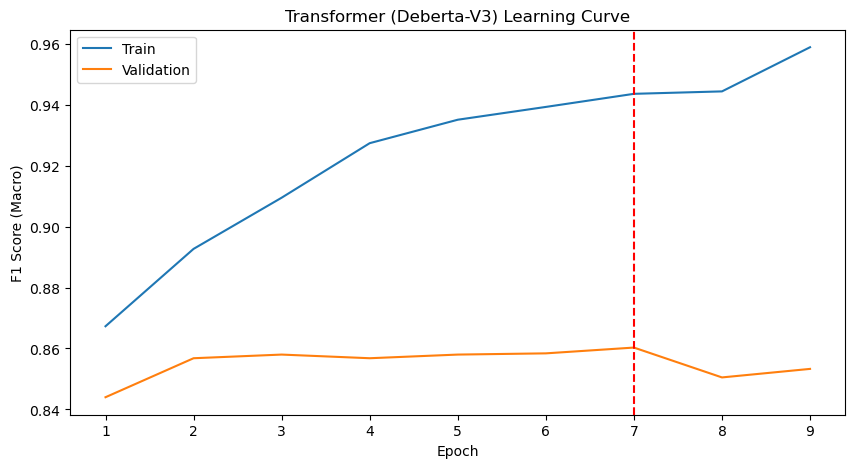

In [59]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_f1s, val_f1s):
    N = len(train_f1s)
    plt.figure(figsize=(10, 5))
    # plt.plot(train_f1s, label="Train")
    # plt.plot(val_f1s, label="Validation")
    plt.xlabel("Epoch")
    plt.plot(range(1, N+1), train_f1s, label="Train")
    plt.plot(range(1, N+1), val_f1s, label="Validation")
    plt.axvline(x=7, color='red', linestyle='--', linewidth=1.5) # , label="overfitting threshold")
    plt.xticks([i for i in range(1, N+1)])
    plt.ylabel("F1 Score (Macro)")
    plt.title("Transformer (Deberta-V3) Learning Curve")
    plt.legend()
    plt.savefig("pretrained_transformer_f1_score_curve.png")

plot_learning_curve(best_model_train_f1, best_model_val_f1)

/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/936105137.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_31811/936105137.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


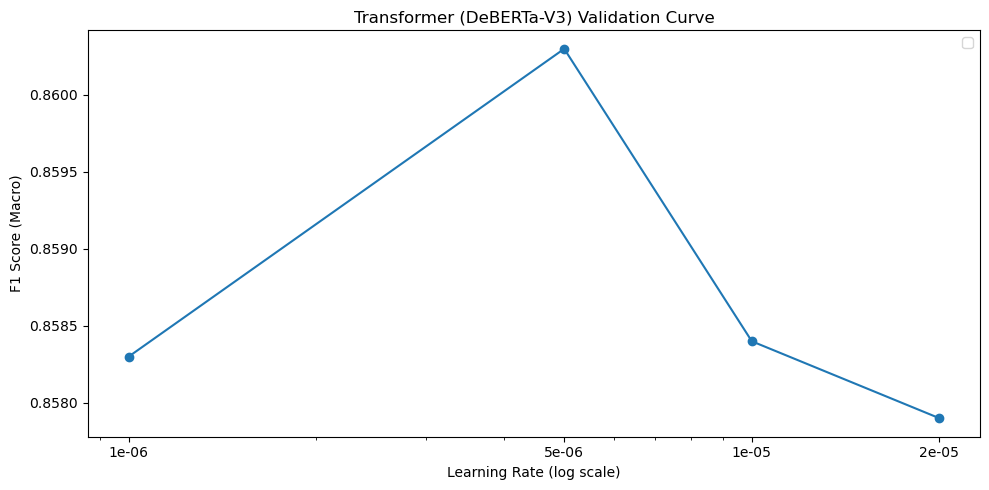

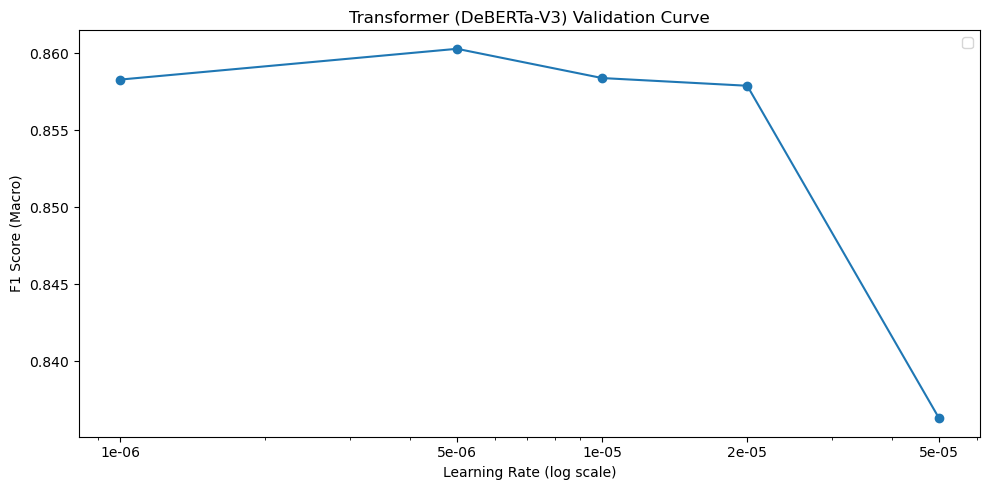

In [60]:
import matplotlib.pyplot as plt

def plot_validation_curve(xticks, log_scale, val_f1s, filename):
    plt.figure(figsize=(10, 5))

    if log_scale:
        # Log-scale line plot
        plt.semilogx(xticks, val_f1s, marker="o") # , label="Validation")
        plt.xticks(xticks, [f"{x:.0e}" for x in xticks])
    else:
        plt.plot(xticks, val_f1s) # , label="Validation")

    plt.xlabel("Learning Rate (log scale)" if log_scale else "Learning Rate")
    plt.ylabel("F1 Score (Macro)")
    plt.title("Transformer (DeBERTa-V3) Validation Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)

# learning_rate=1e-6, batch_size=16 (EPOCH 16, val_f1=0.8583, test_f1=0.848050)
# learning_rate=5e-6, batch_size=16 (EPOCH 7, val_f1=0.8603, test_f1=0.85244) => BEST
# learning_rate=1e-5, batch_size=16 (EPOCH 5, val_f1=0.8584, test_f1=0.85042)
# learning_rate=2e-5, batch_size=16 (EPOCH 3, val_f1=0.8579, test_f1=0.85392)
# learning_rate=5e-5, batch_size=16 (EPOCH 2, val_f1=0.8363, test_f1=0.836272)

# learning_rate=1e-4, batch_size=16 (EPOCH 1~3, val_f1=0.2623)

val_f1_scores = [0.8583, 0.8603, 0.8584, 0.8579] # , 0.2623]
learning_rates = [1e-6, 5e-6, 1e-5, 2e-5]
plot_validation_curve(learning_rates, True, val_f1_scores, "pretrained_transformer_f1_score_val_curve1.png")
# learning_rates = ["1e-6\n(epoch=16)", "5e-6\n(epoch=7)", "1e-5\n(epoch=5)", "2e-5\n(epoch=3)"]
# plot_validation_curve(learning_rates, False, val_f1_scores, "pretrained_transformer_f1_score_val_curve_epoch1.png")

val_f1_scores = [0.8583, 0.8603, 0.8584, 0.8579, 0.8363] # , 0.2623]
learning_rates = [1e-6, 5e-6, 1e-5, 2e-5, 5e-5]
plot_validation_curve(learning_rates, True, val_f1_scores, "pretrained_transformer_f1_score_val_curve2.png")
# learning_rates = ["1e-6\n(epoch=16)", "5e-6\n(epoch=7)", "1e-5\n(epoch=5)", "2e-5\n(epoch=3)", "5e-5\n(epoch=2)"]
# plot_validation_curve(learning_rates, False, val_f1_scores, "pretrained_transformer_f1_score_val_curve_epoch2.png")

# Trash

In [61]:
# trainer = train(epoch=10, learning_rate=2e-5, batch_size=8, output_dir="./deberta-v3-crisis/2")
# eval_results = trainer.evaluate(tokenized_datasets["test"])
# print(eval_results)

#  # [38186/76370 4:35:02 < 4:35:02, 2.31 it/s, Epoch 5/10]
# # Epoch	Training Loss	Validation Loss	Accuracy	Precision	Recall	F1
# # 1	No log	0.341084	0.901881	0.866828	0.888816	0.873895
# # 2	No log	0.218777	0.935504	0.909765	0.919633	0.913919
# # 3	No log	0.164746	0.959142	0.939431	0.952655	0.945791
# # 4	No log	0.109434	0.973907	0.963635	0.966295	0.964884
# # 5	No log	0.087381	0.982927	0.976098	0.977472	0.976734


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_95996/312600777.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.341084,0.901881,0.866828,0.888816,0.873895
2,No log,0.218777,0.935504,0.909765,0.919633,0.913919
3,No log,0.164746,0.959142,0.939431,0.952655,0.945791
4,No log,0.109434,0.973907,0.963635,0.966295,0.964884
5,No log,0.087381,0.982927,0.976098,0.977472,0.976734


KeyboardInterrupt: 

In [28]:
# trainer = train(epoch=10, learning_rate=2e-5, batch_size=64, output_dir="./deberta-v3-crisis/batchsize64")
# # eval_results = trainer.evaluate(tokenized_datasets["test"])
# # print(eval_results)

# #  [ 272/2710 07:04 < 1:03:52, 0.64 it/s, Epoch 1/10]
# # Step	Training Loss	Validation Loss	Accuracy	Precision	Recall	F1
# # 271	No log	0.360962	0.870866	0.835089	0.818979	0.824688

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_8707/281152571.py:115: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
271,No log,0.319999,0.888491,0.851906,0.849513,0.849046



[EPOCH 1]
[train] acc=0.8885, prec=0.8519, rec=0.8495, f1=0.8490
[valid] acc=0.8709, prec=0.8351, rec=0.8190, f1=0.8247


KeyboardInterrupt: 

In [14]:
# trainer = train(epoch=10, learning_rate=2e-5, batch_size=64, output_dir="./deberta-v3-crisis/batchsize64_1")
# eval_results = trainer.evaluate(tokenized_datasets["test"])
# print(eval_results)
# #  [1014/9550 1:00:22 < 8:29:14, 0.28 it/s, Epoch 1.06/10]
# # Epoch	Training Loss	Validation Loss	Accuracy	Precision	Recall	F1
# # 1	No log	0.262881	0.903174	0.863936	0.888640	0.874394

# # ================================================================================
# # [EPOCH 1]
# #   [train] acc=0.9032, prec=0.8639, rec=0.8886, f1=0.8744  (n=None)

# # Batch size can't be as high as 256?
# # RuntimeError: MPS backend out of memory (MPS allocated: 27.10 GB, other allocations: 832.00 KB, max allowed: 27.20 GB). Tried to allocate 375.29 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_8707/3149821493.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.262881,0.903174,0.863936,0.888640,0.874394



[EPOCH 1]
  [train] acc=0.9032, prec=0.8639, rec=0.8886, f1=0.8744  (n=None)


KeyboardInterrupt: 

In [10]:

from transformers import TrainerCallback

class TrainMetricsCallback(TrainerCallback):
    def __init__(self, train_dataset):
        super().__init__()
        self.train_dataset = train_dataset
        self.trainer = None
        self.last_eval_metrics = None

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if any(k.startswith("eval_") for k in metrics.keys()):
            self.last_eval_metrics = metrics

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            return control

        train_metrics = self.trainer.evaluate(
            eval_dataset=self.train_dataset,
            metric_key_prefix="train", # train_accuracy, train_f1, ...
        )

        epoch = state.epoch
        train_acc = train_metrics.get("train_accuracy", None)
        train_f1  = train_metrics.get("train_f1", None)

        val_acc = None
        val_f1  = None
        if self.last_eval_metrics is not None:
            val_acc = self.last_eval_metrics.get("eval_accuracy", None)
            val_f1  = self.last_eval_metrics.get("eval_f1", None)

        print("\n" + "=" * 80)
        print(f"[EPOCH {epoch:.0f}]")
        if train_acc is not None and train_f1 is not None:
            print(f"  train_acc = {train_acc:.4f}, train_f1 = {train_f1:.4f}")
        if val_acc is not None and val_f1 is not None:
            print(f"  val_acc   = {val_acc:.4f}, val_f1   = {val_f1:.4f}")
        print("=" * 80)

        return control


def train(epoch=3, learning_rate=2e-5, batch_size=16, output_dir="./deberta-v3-crisis/1"):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_strategy="epoch",
        report_to="none",
    )

    train_callback = TrainMetricsCallback(tokenized_datasets["train"])

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[train_callback],
    )

    train_callback.trainer = trainer
    
    trainer.train()
    return trainer

In [11]:
# trainer = train(epoch=3, learning_rate=2e-5, batch_size=64, output_dir="./deberta-v3-crisis/test2")
# eval_results = trainer.evaluate(tokenized_datasets["test"])
# print(eval_results)

# # Batch size can't be as high as 256?
# # RuntimeError: MPS backend out of memory (MPS allocated: 27.10 GB, other allocations: 832.00 KB, max allowed: 27.20 GB). Tried to allocate 375.29 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_8707/2795326635.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.265105,0.901373,0.860023,0.890323,0.873302
2,No log,0.204079,0.928432,0.897973,0.917152,0.907176



[EPOCH 1]
  train_acc = 0.9014, train_f1 = 0.8733

[EPOCH 2]
  train_acc = 0.9284, train_f1 = 0.9072


KeyboardInterrupt: 

In [28]:
# trainer = train(epoch=3, learning_rate=2e-5, batch_size=16, output_dir="./deberta-v3-crisis/1")

# # Epoch	Training Loss	Validation Loss	Accuracy	Precision	Recall  	F1
# # 1	    0.311500	    0.322661	    0.888241	0.851410	0.855949	0.852308
# # 2	    0.239700	    0.300615	    0.893398	0.853491	0.866558	0.859771

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/s4/0k6rg3jx501349m2r7df_0_w0000gn/T/ipykernel_84643/3190309381.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.311500,0.322661,0.888241,0.851410,0.855949,0.852308
2,0.239700,0.300615,0.893398,0.853491,0.866558,0.859771


KeyboardInterrupt: 

In [17]:
import torch, gc
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()